## Highly recommended to put contents of this notebook in a script and run in tmux session since training may take some time

### Import Dependencies

#### Note that unet.py is in the same directory and contains model architecture, loss function, and metric functin

In [1]:
from fastai.vision import *
from fastai import *
from fastai.data_block import *

from pathlib import Path

from unet import eval_preds, VolumetricUnet, dice_loss, dice_score, predict, plot_predictions
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import FloatTensor as FT

### Set Pytorch to use a specific GPU

In [2]:
torch.cuda.set_device(0)

### Data Prep

In [3]:
data_path = Path("/data/public/Segmentation_Dataset/MR_Dataset_Atlas")
trn_img = sorted(list(Path(data_path/"train/skull_stripped").iterdir()))
trn_mask = sorted(list(Path(data_path/"train/ventricle_atlas").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/ventricle_masks").iterdir()))

In [4]:
print(f"Size of Train Dataset: {len(trn_img)} Images")
print(f"Size of Validation Dataset: {len(valid_img)} Images")

Size of Train Dataset: 2143 Images
Size of Validation Dataset: 15 Images


In [5]:
class MRI_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)
    
train_ds = MRI_3D_Dataset(trn_img, trn_mask)
valid_ds = MRI_3D_Dataset(valid_img, valid_mask)   

data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=3)

### Create 3D Unet

In [6]:
unet = VolumetricUnet(in_channel=1, out_channel=4, num_classes=1)

In [7]:
learner = Learner(data=data, model=unet)

In [8]:
learner.loss_func = dice_loss
learner.metrics = [dice_score]

### We use 16 bit Fixed Precision to allow us to go from 1 image to 3 images in batch size

In [9]:
learner.to_fp16();

### Use Fastai learning rate finder to determine optimal initial learning rate

In [10]:
#learner.lr_find()
# learner.recorder.plot()

## Fit model with learning rate 3e-2 and 5 epochs

In [11]:
# learner.fit_one_cycle(5, 3e-2)

## Save Model weights into current directory

In [12]:
#learner.save('DL_Ventricle_MR_ATLAS_5_epochs_3e-2_lr')

## Load Model

In [10]:
learner.load('DL_Ventricle_MR_ATLAS_5_epochs_3e-2_lr');

## Evaluation

In [11]:
images, preds, masks = predict(learner, data)

/usr/local/share/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


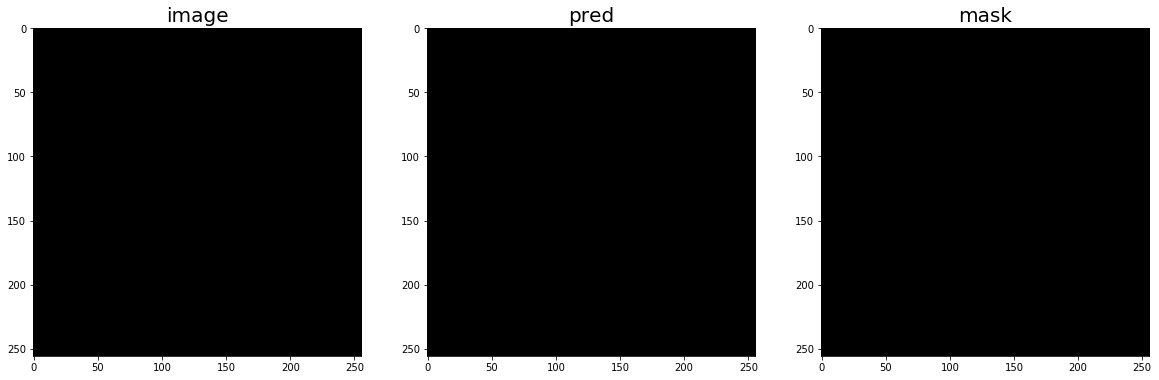

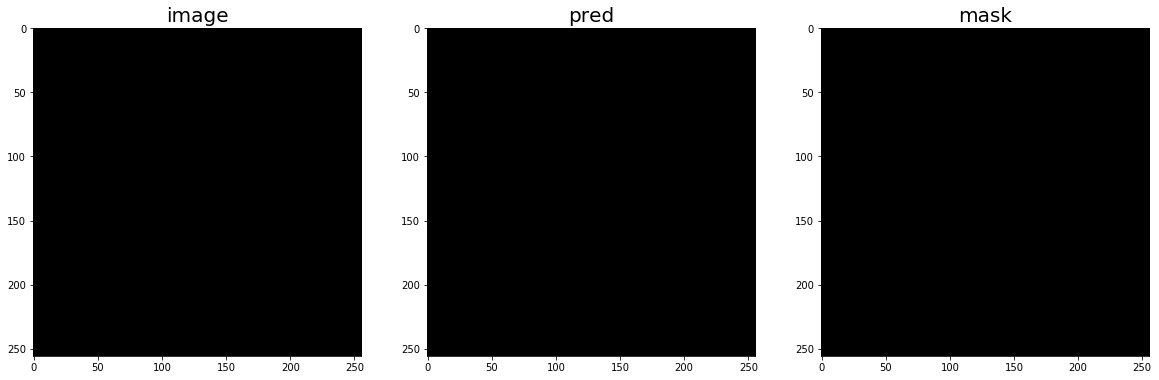

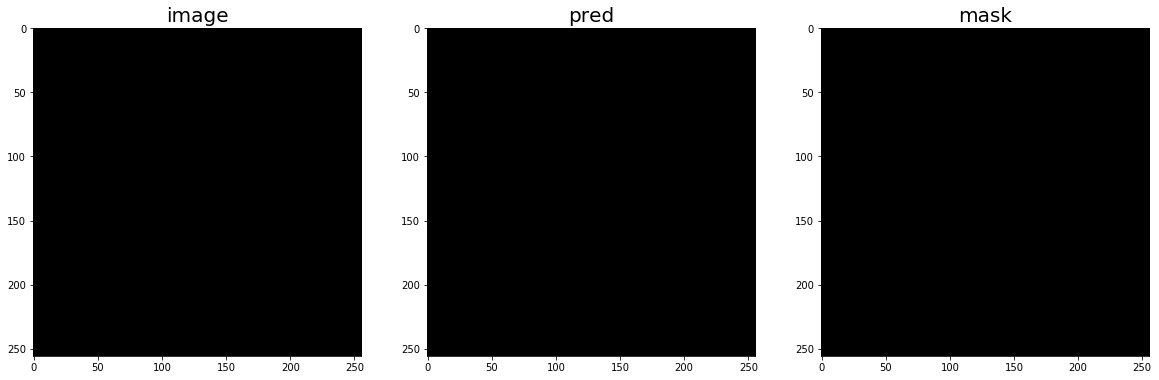

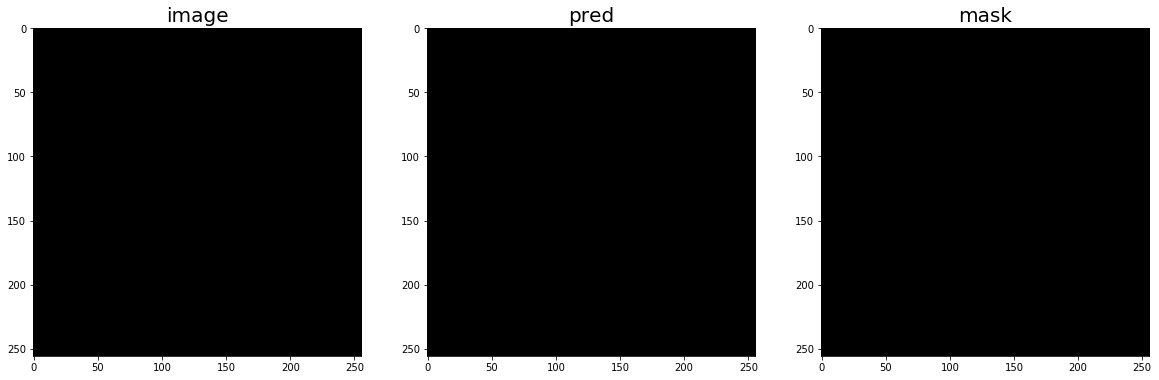

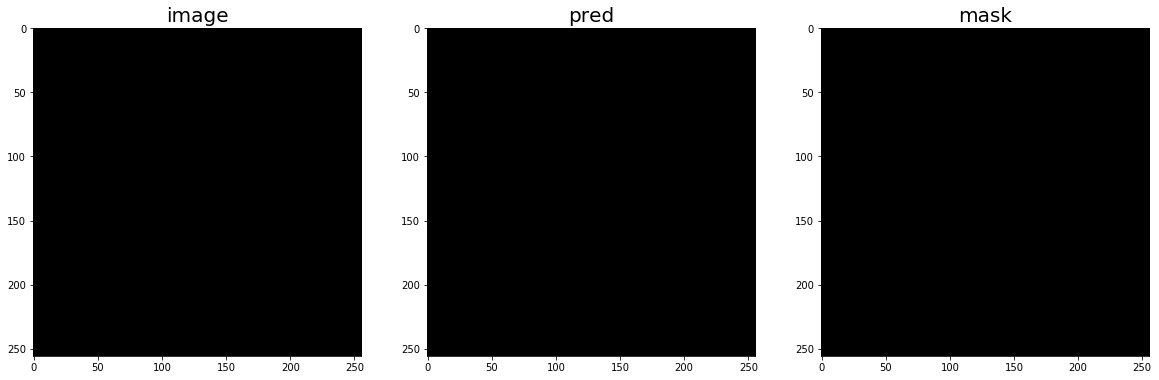

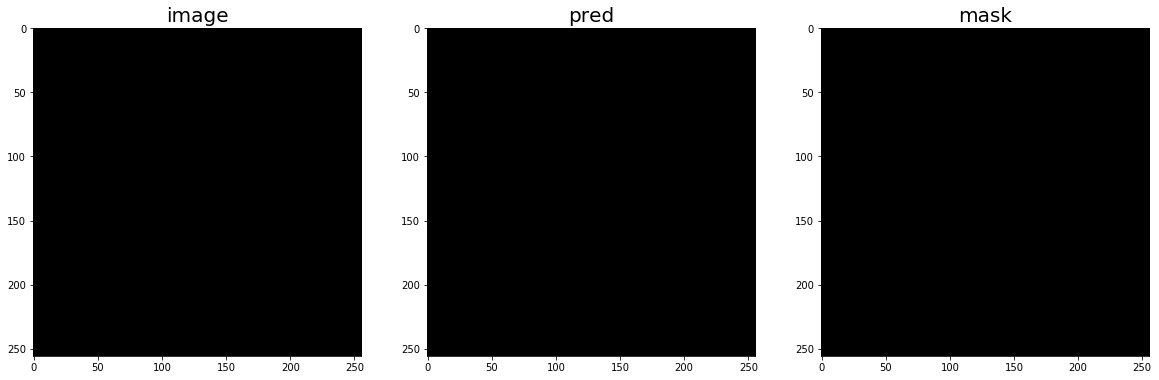

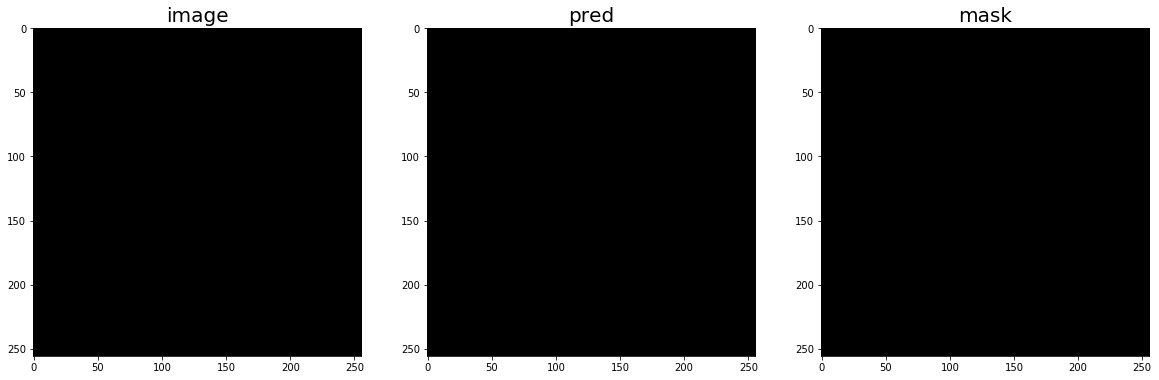

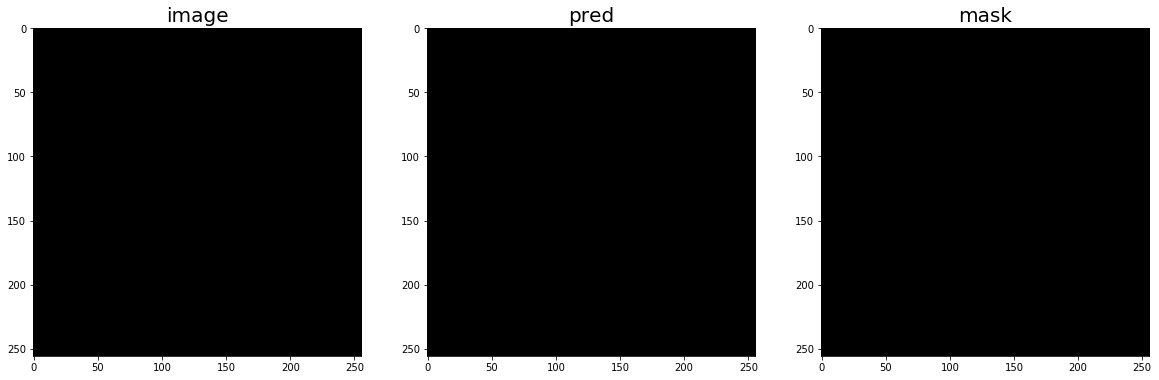

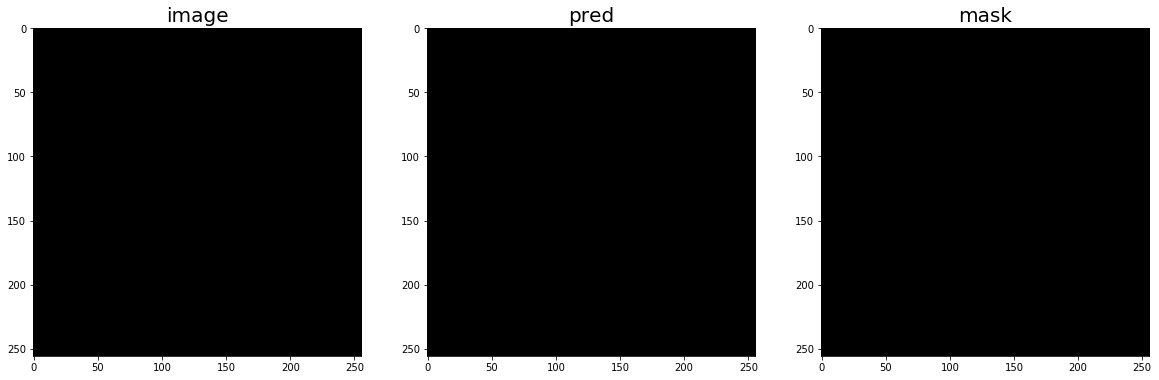

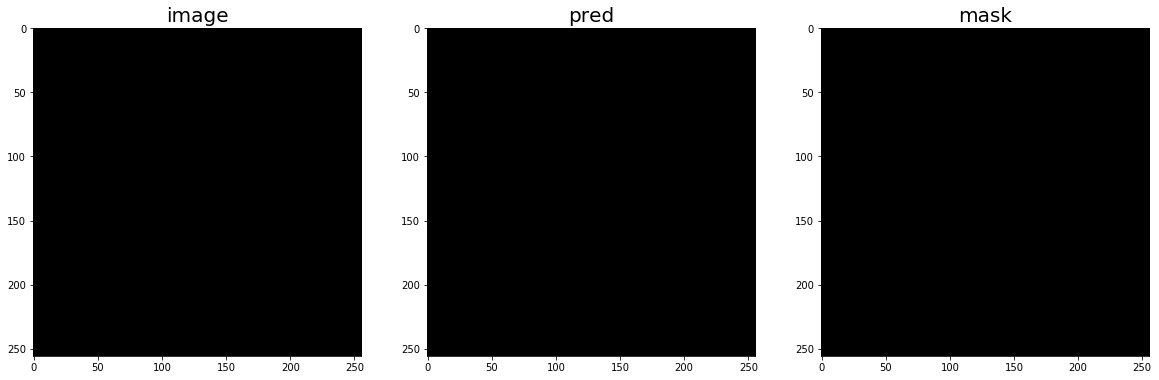

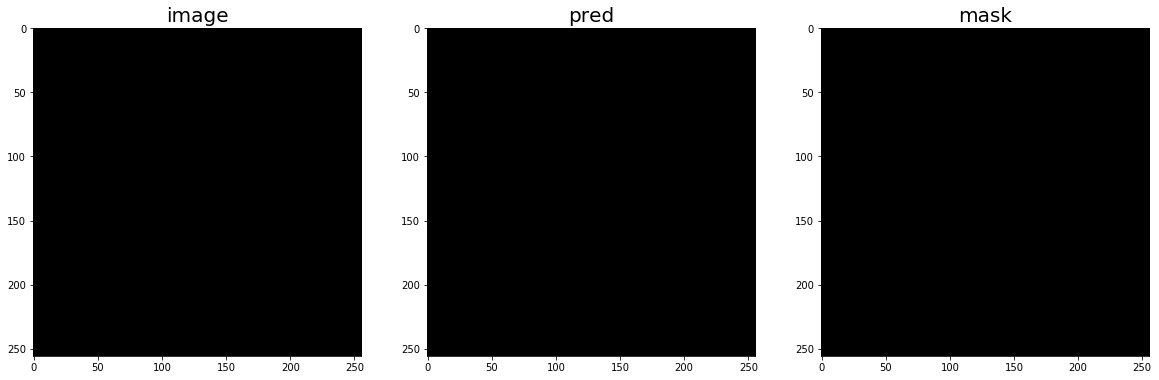

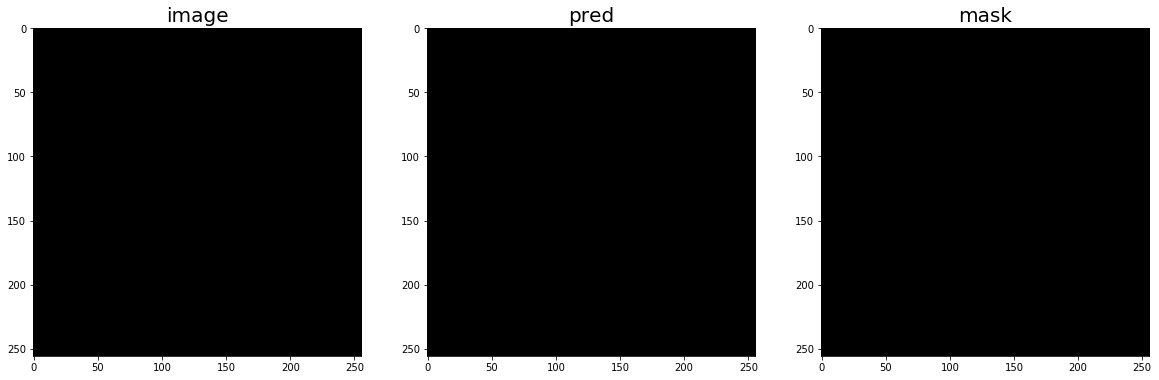

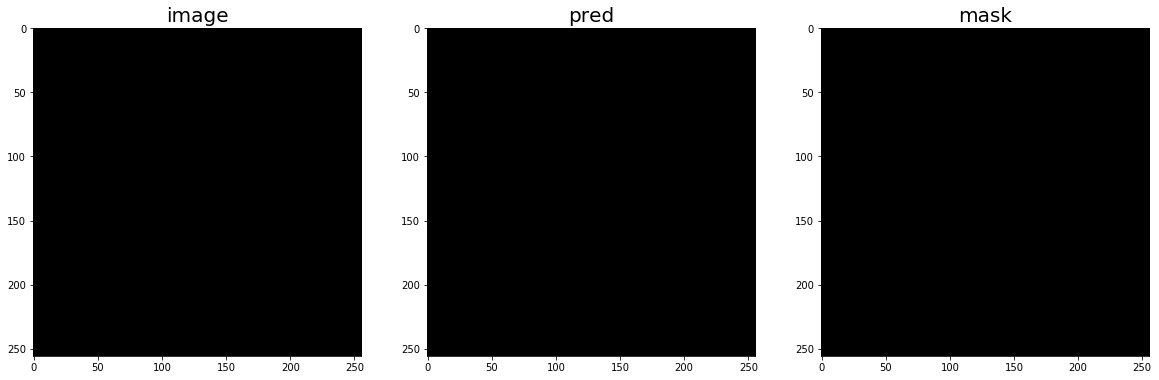

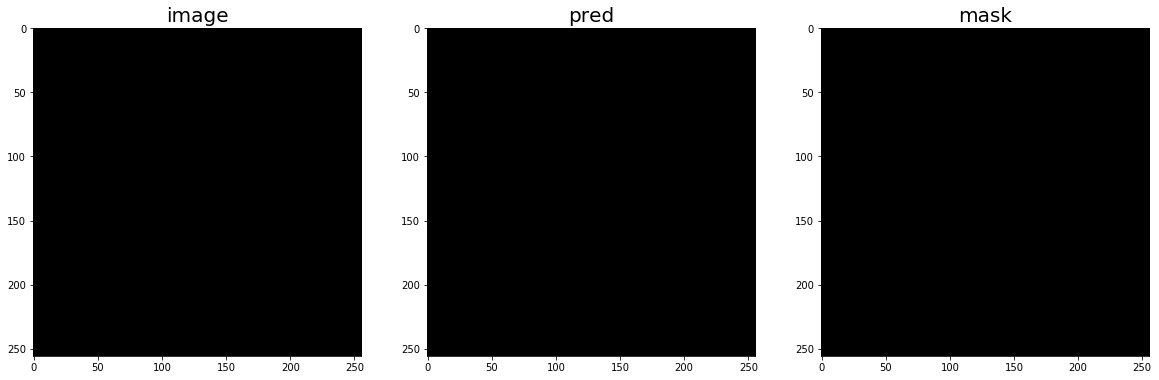

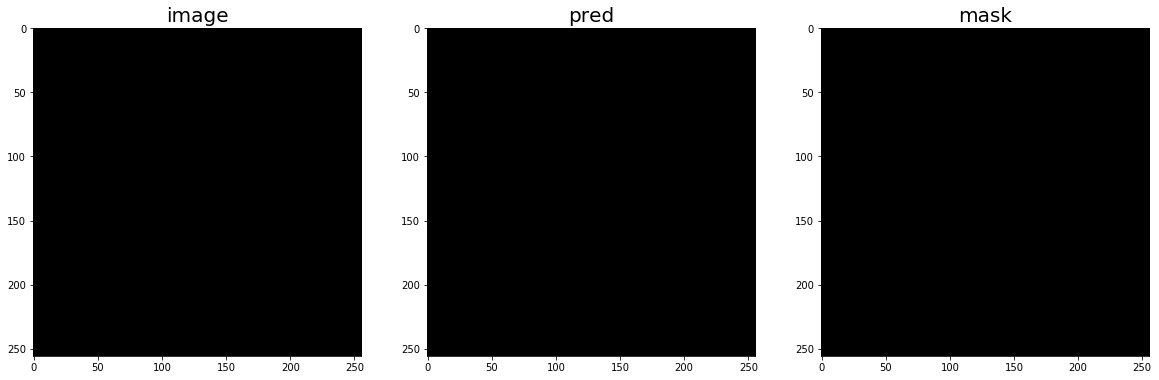

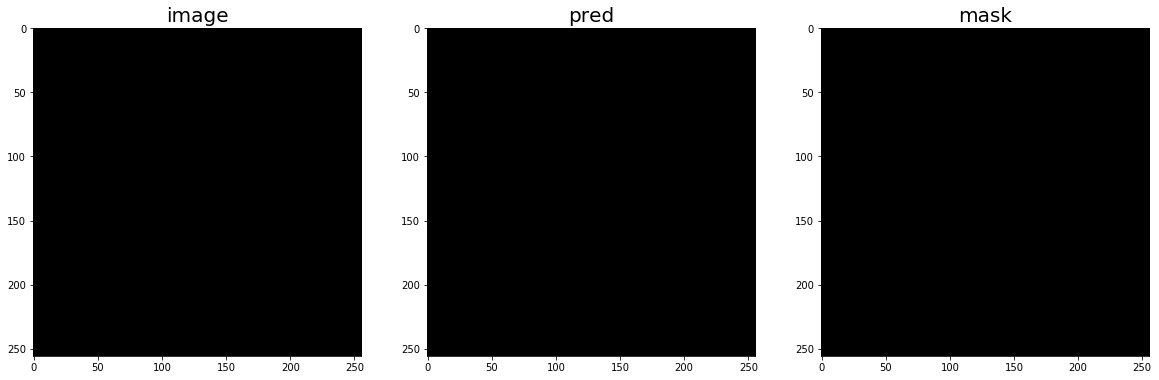

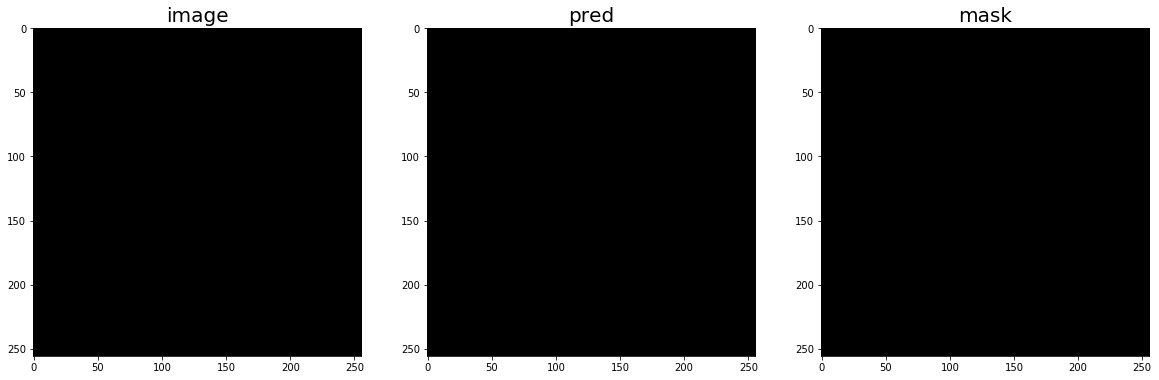

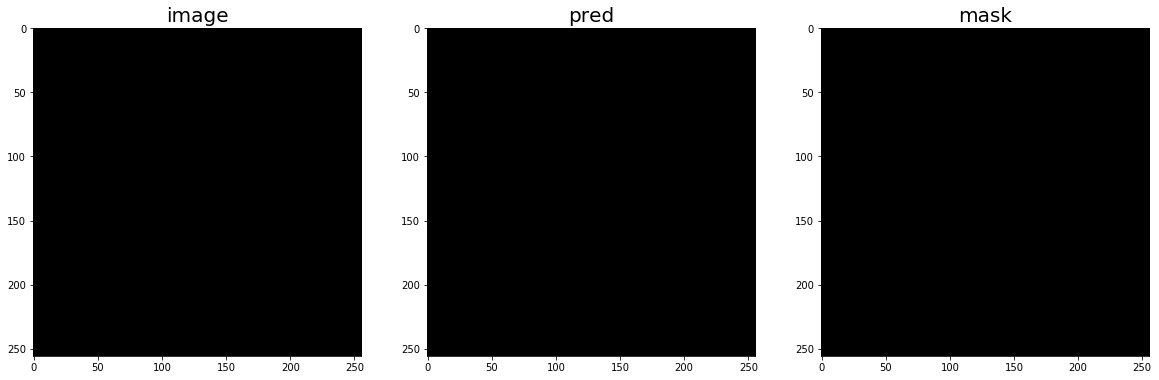

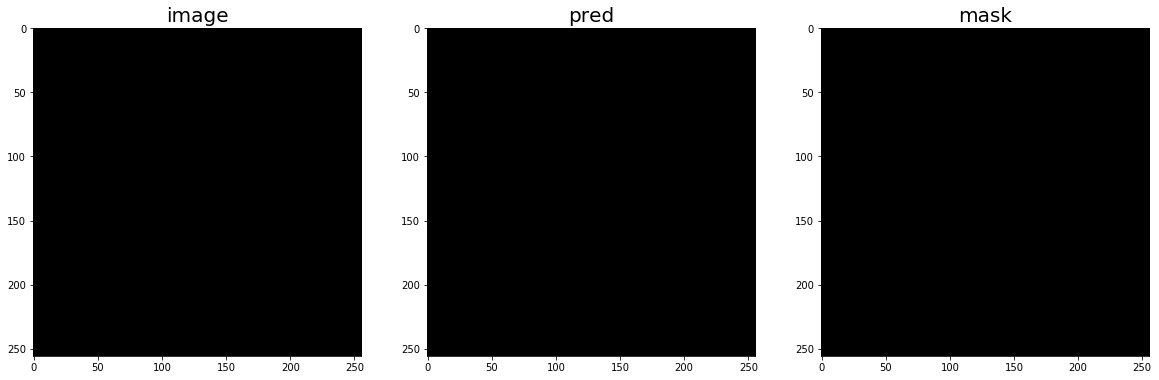

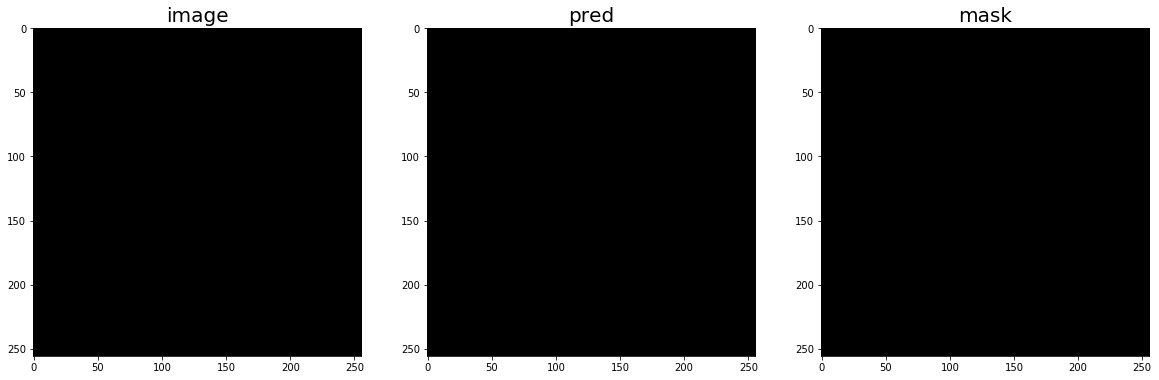

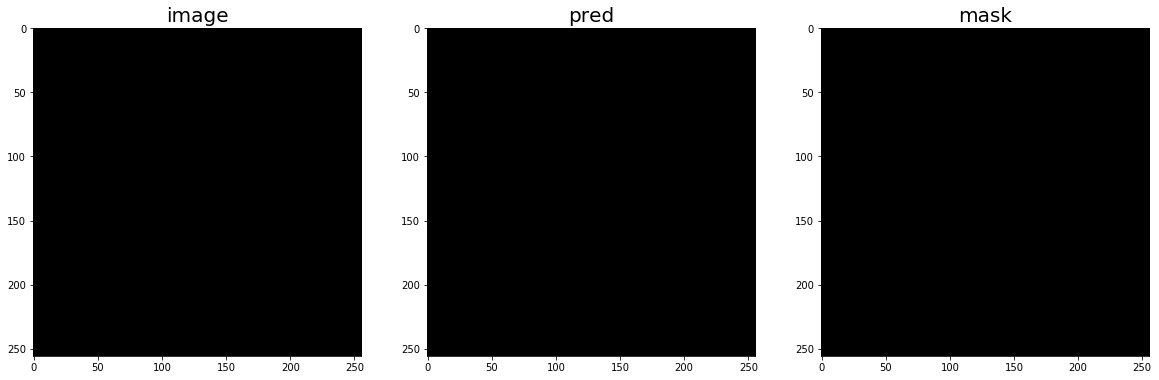

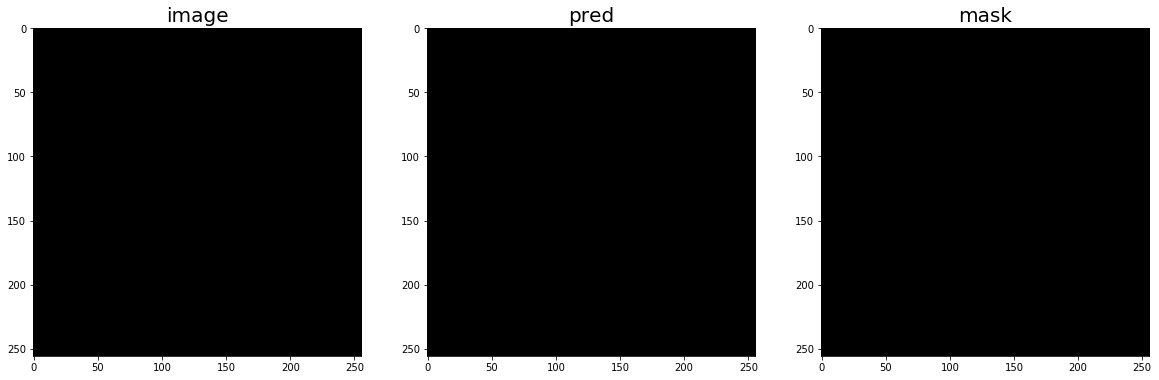

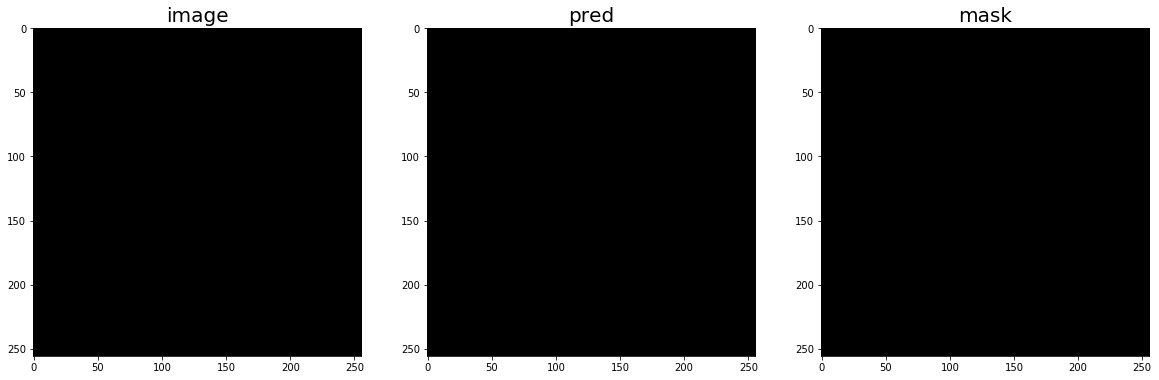

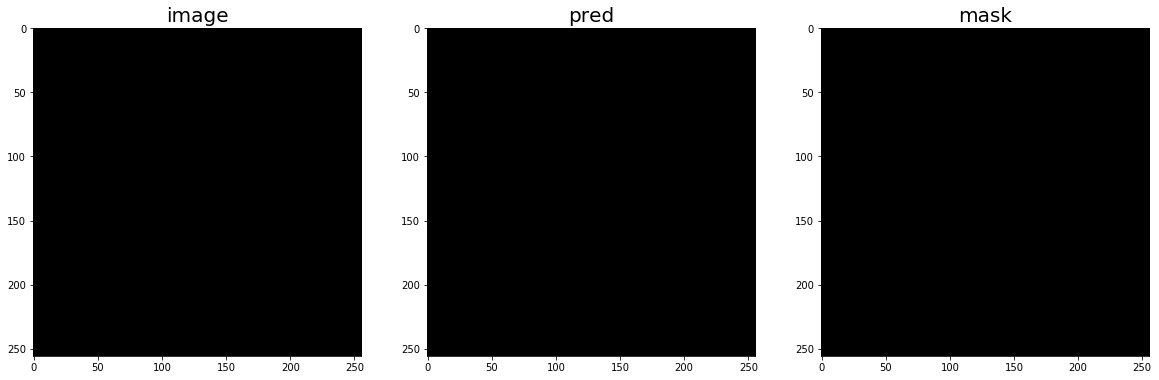

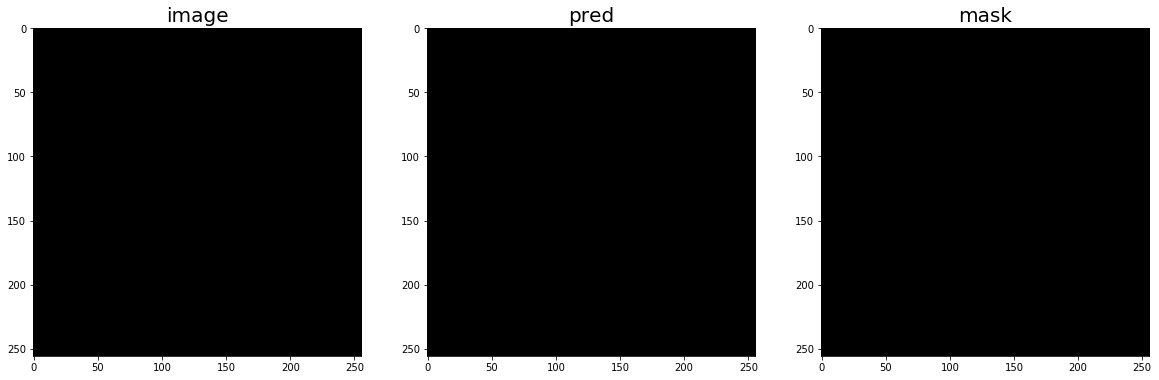

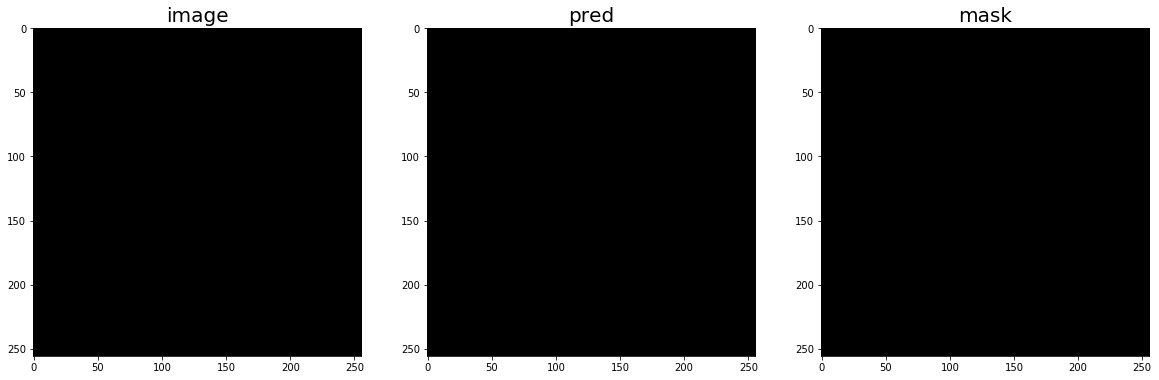

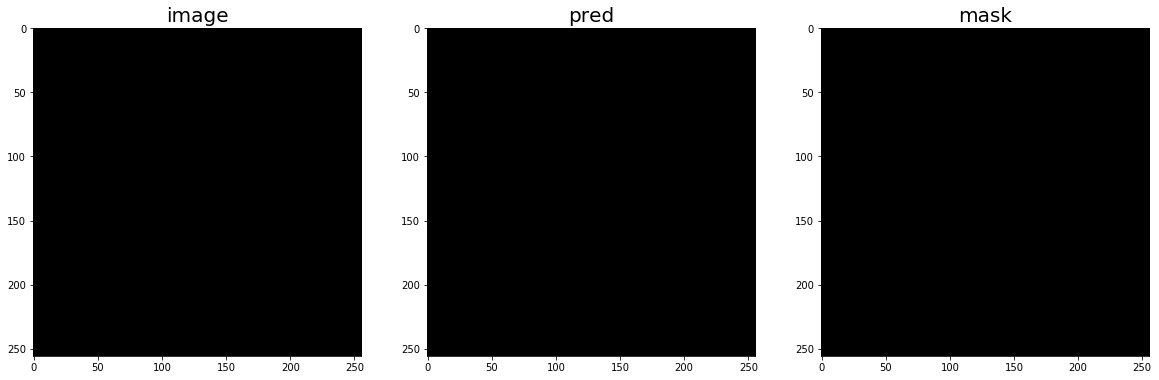

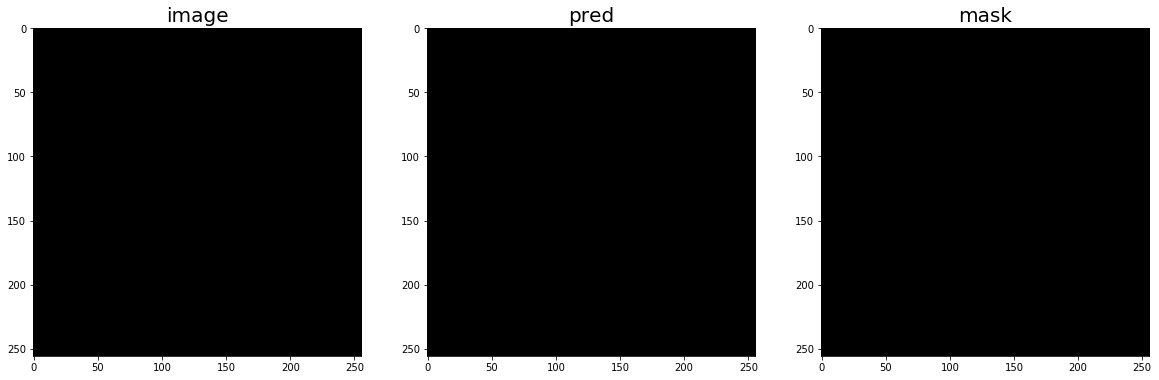

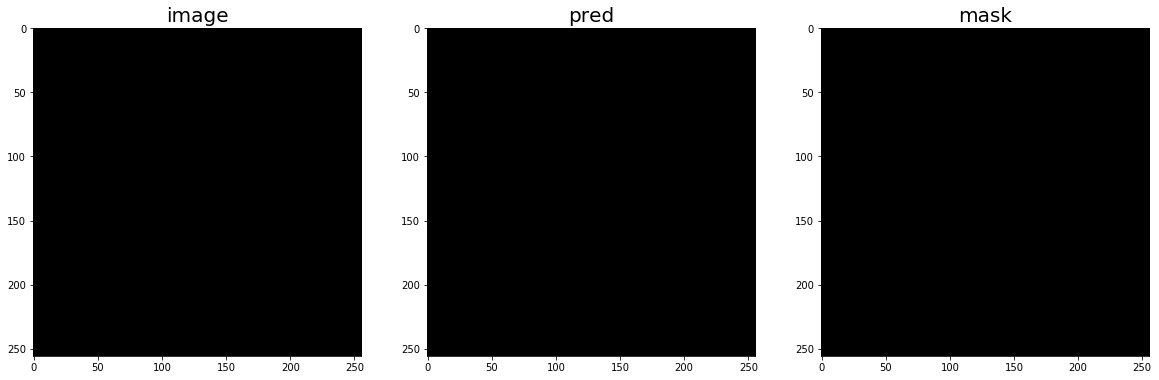

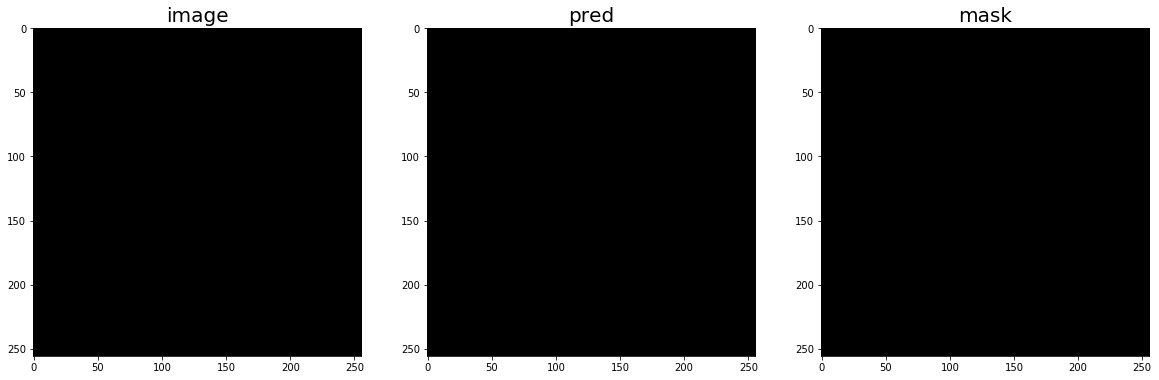

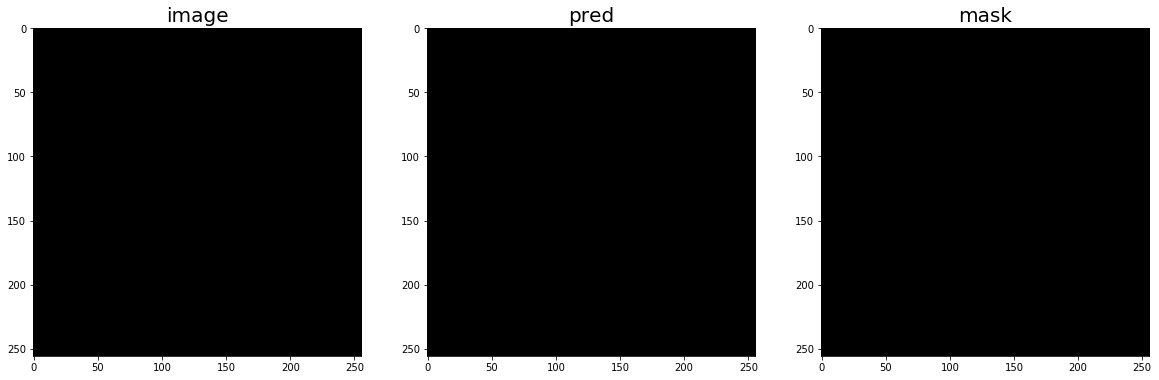

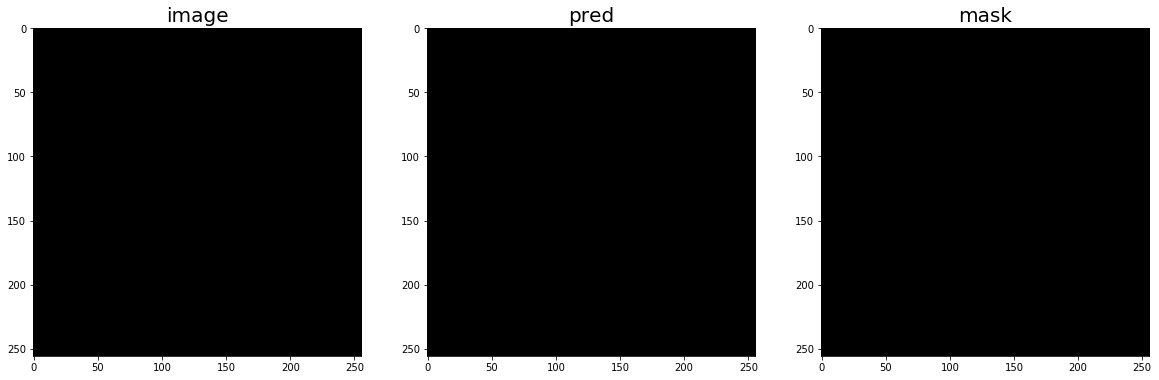

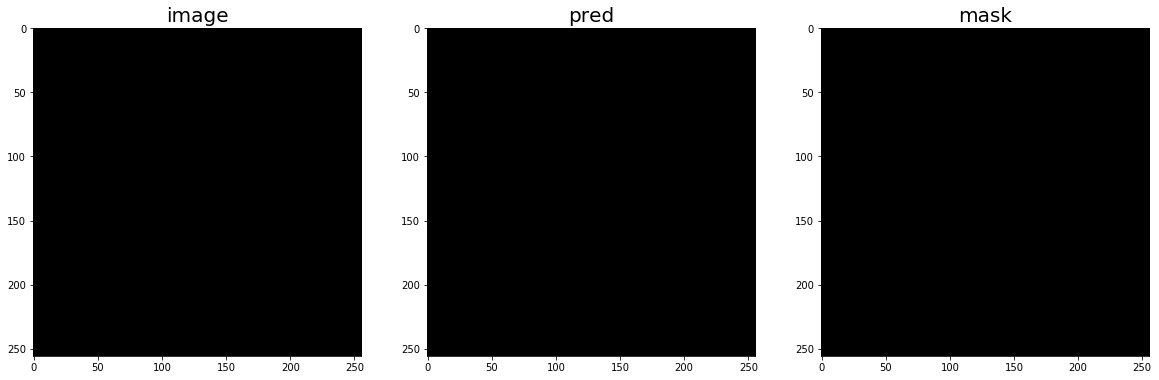

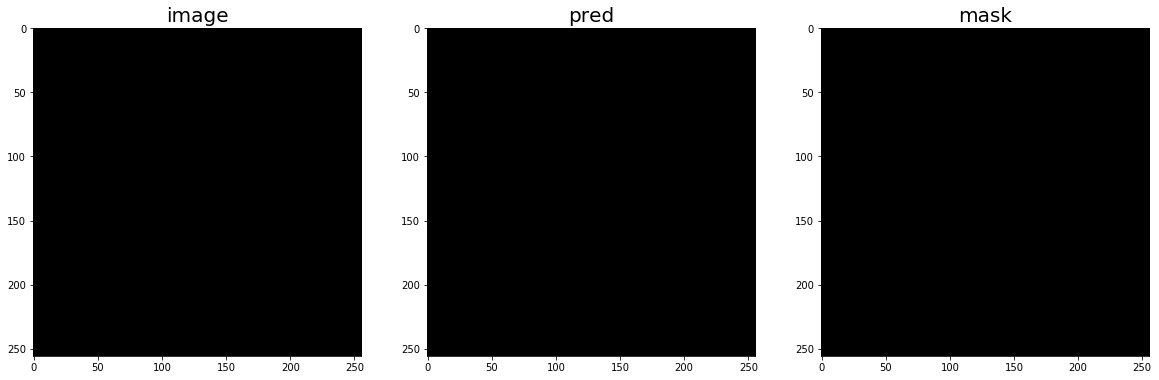

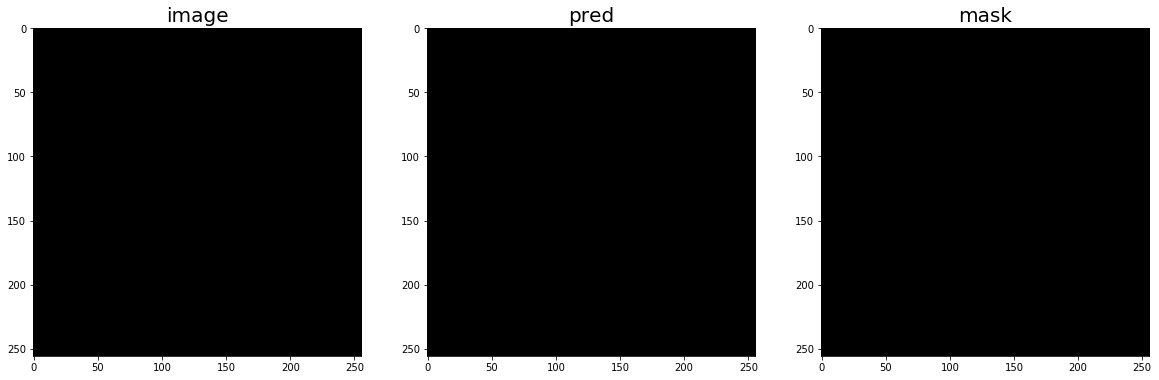

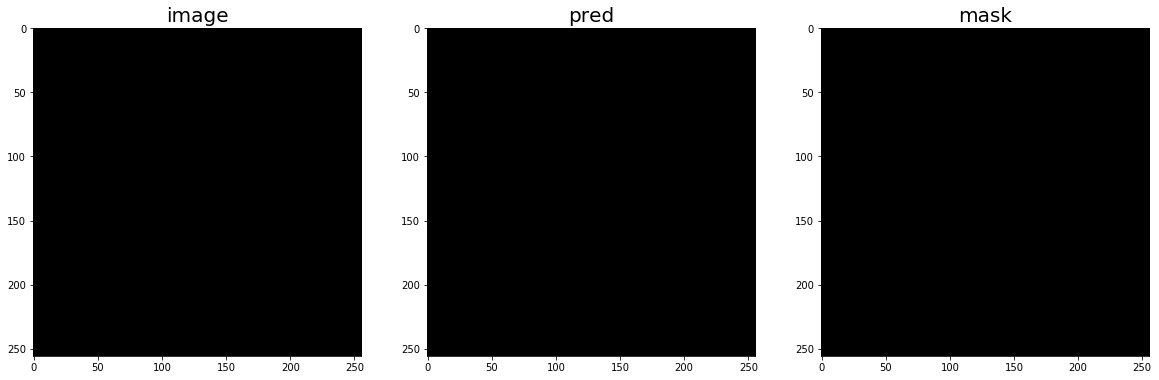

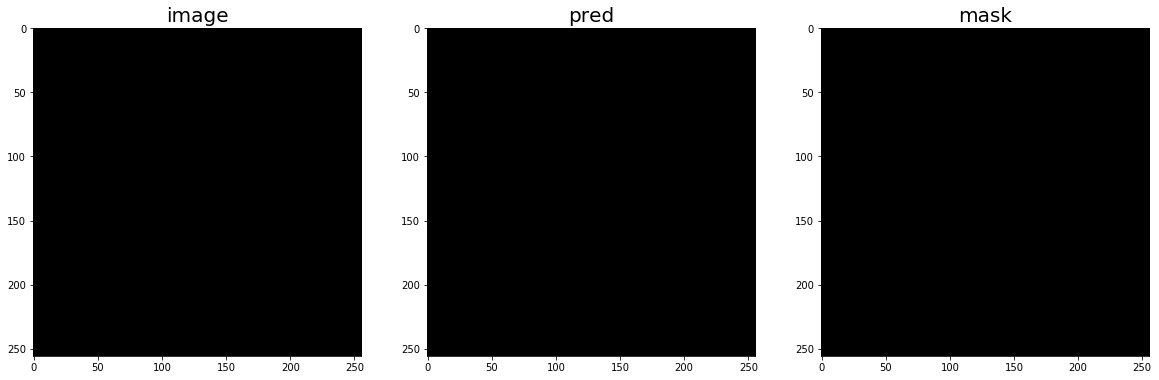

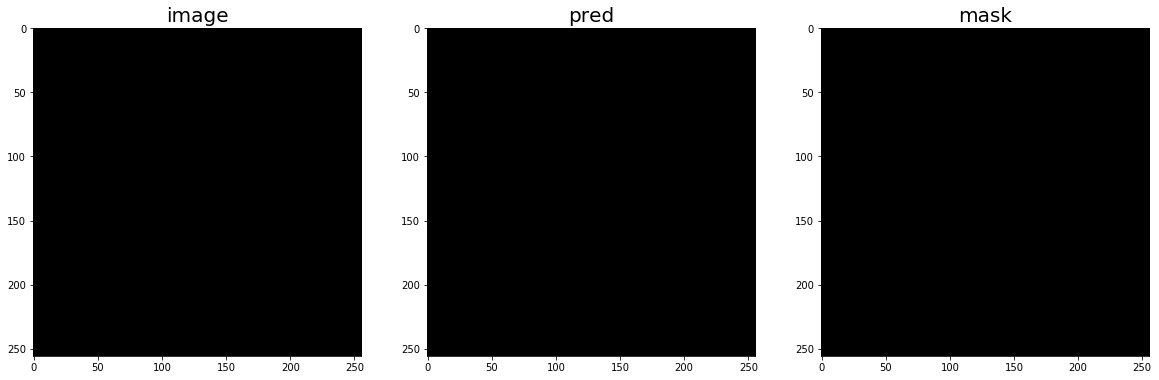

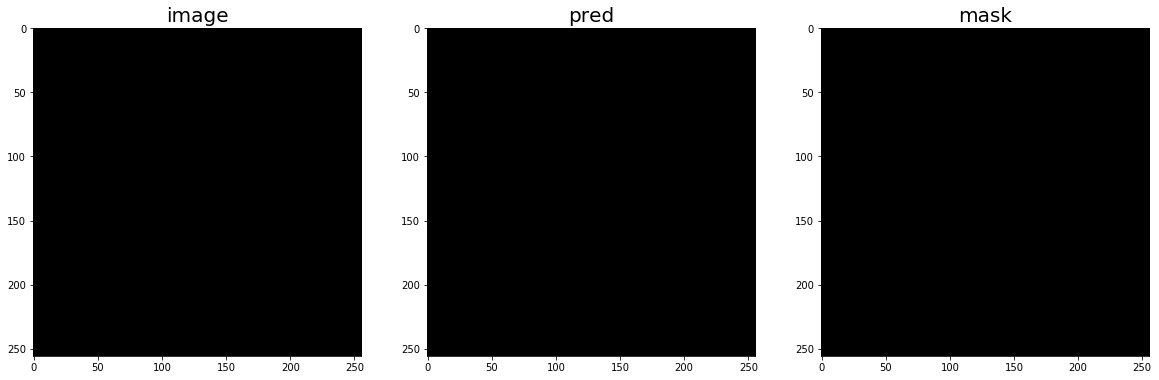

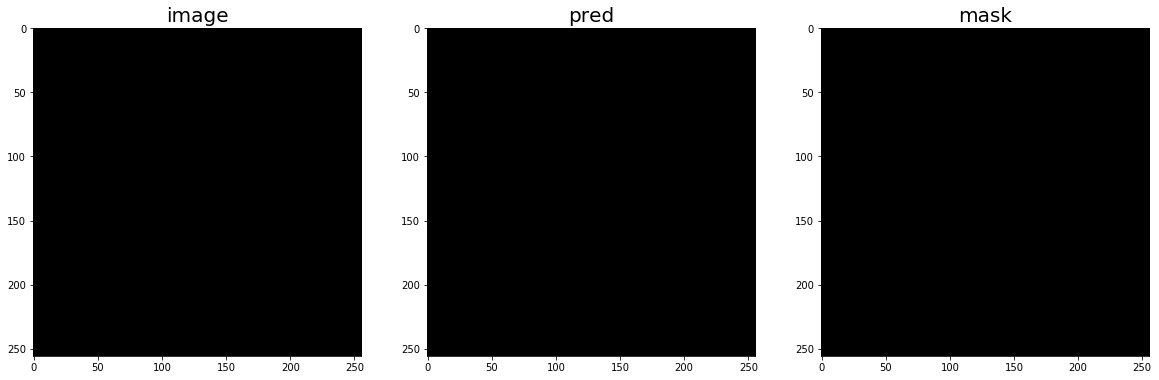

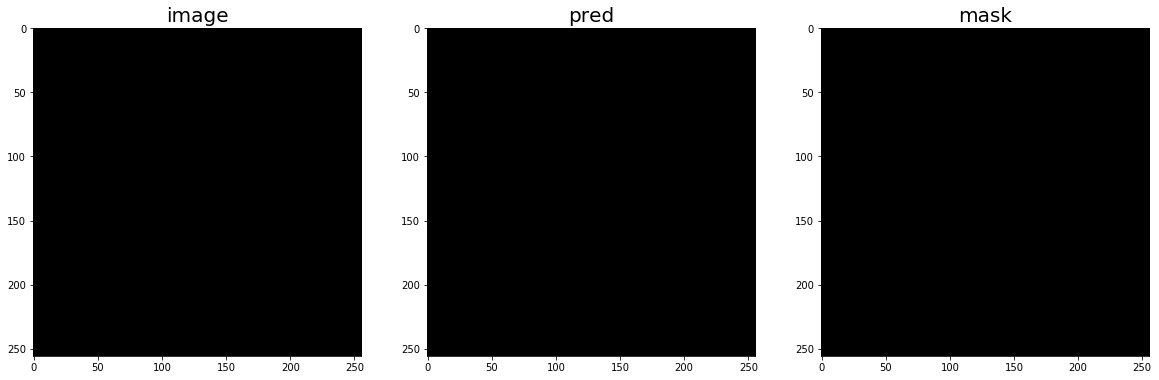

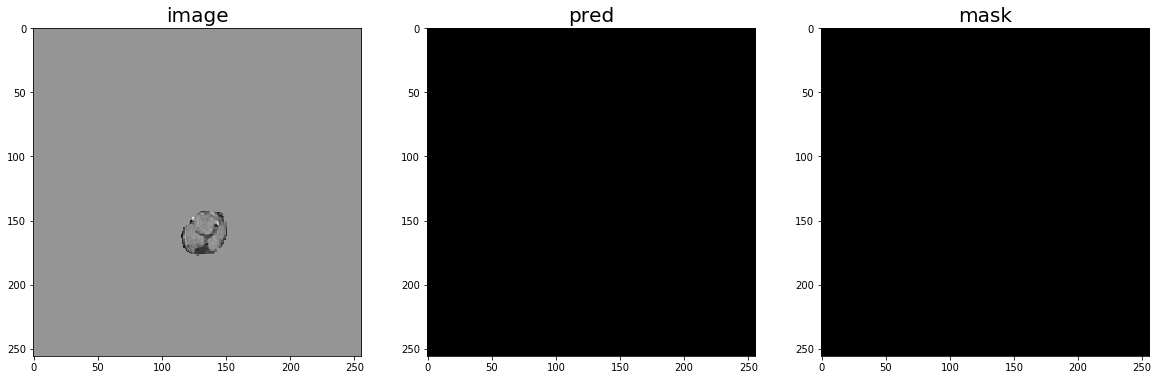

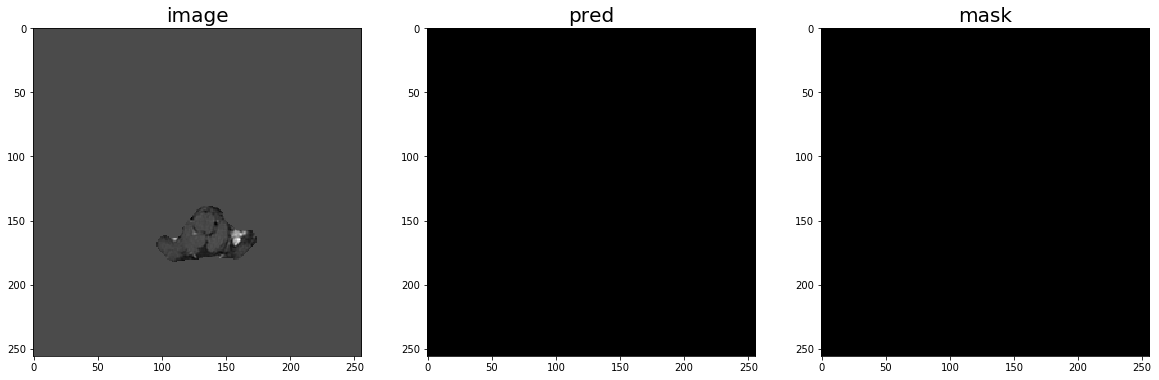

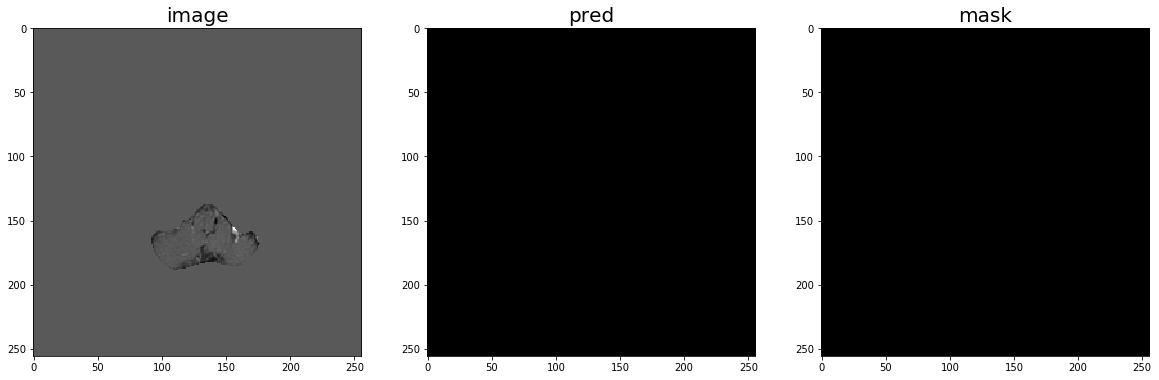

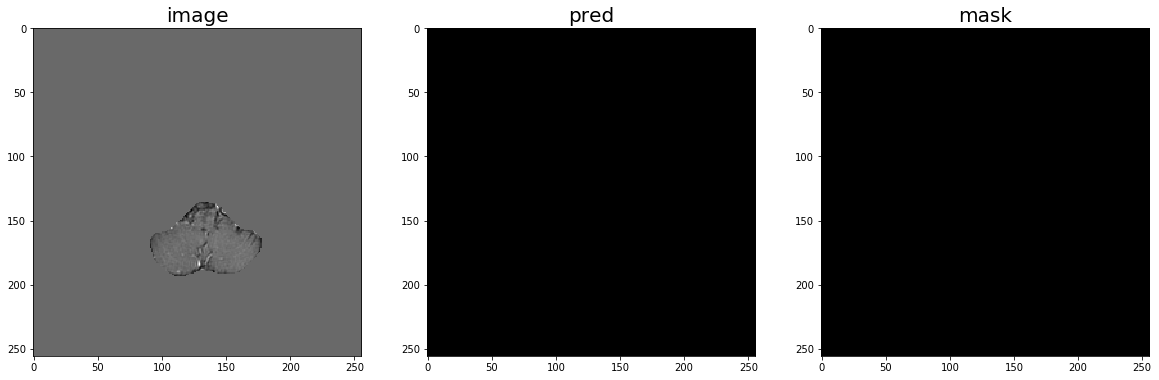

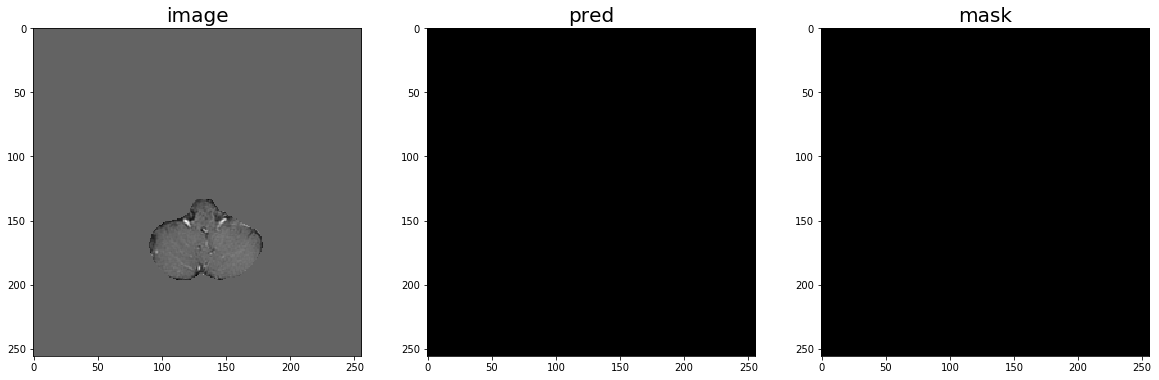

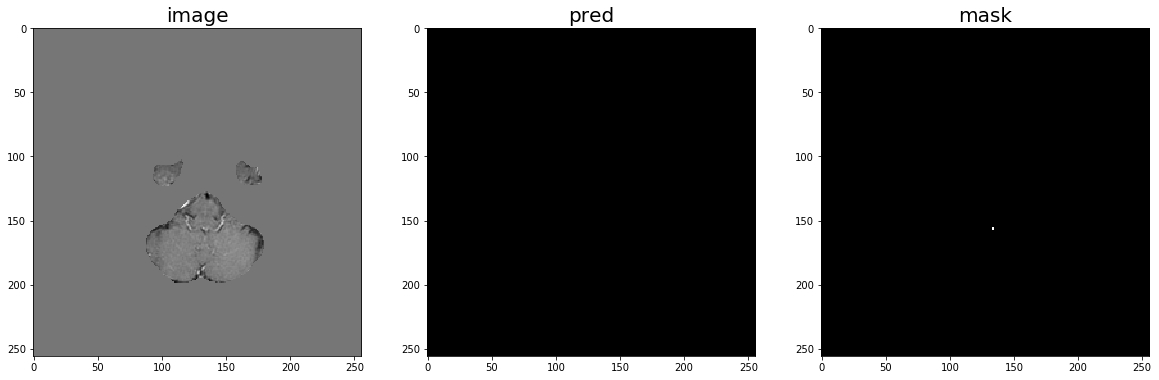

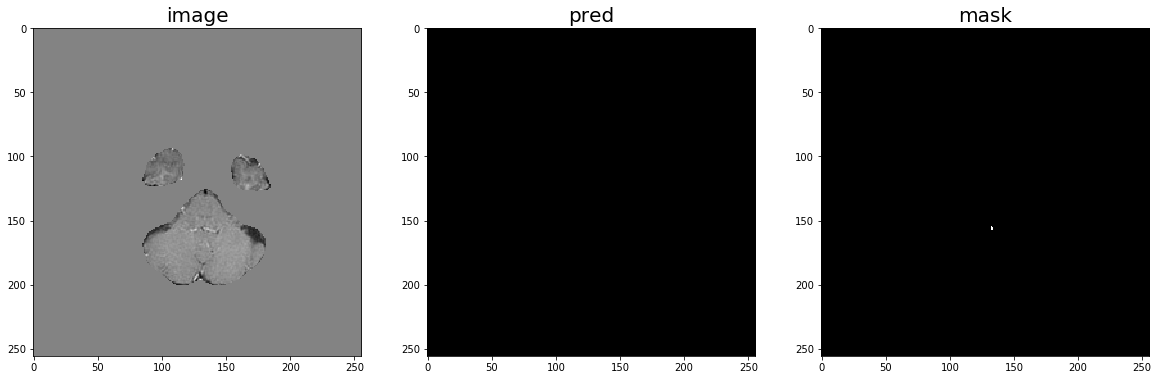

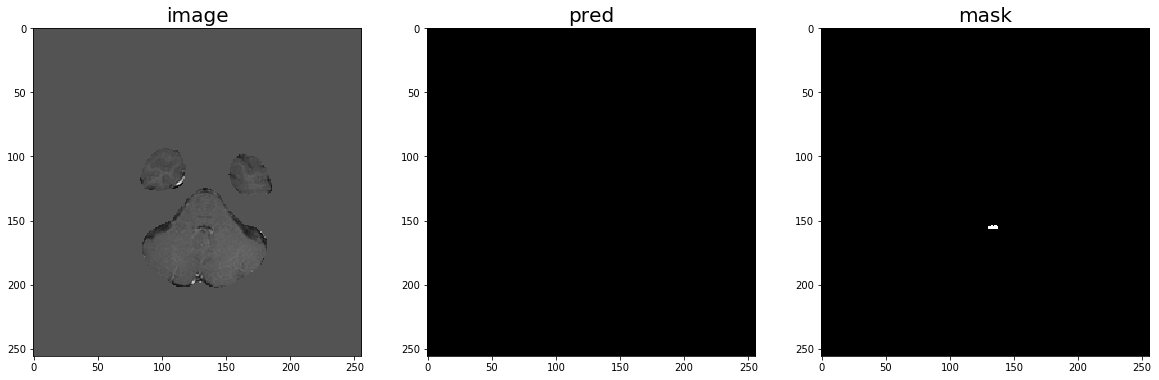

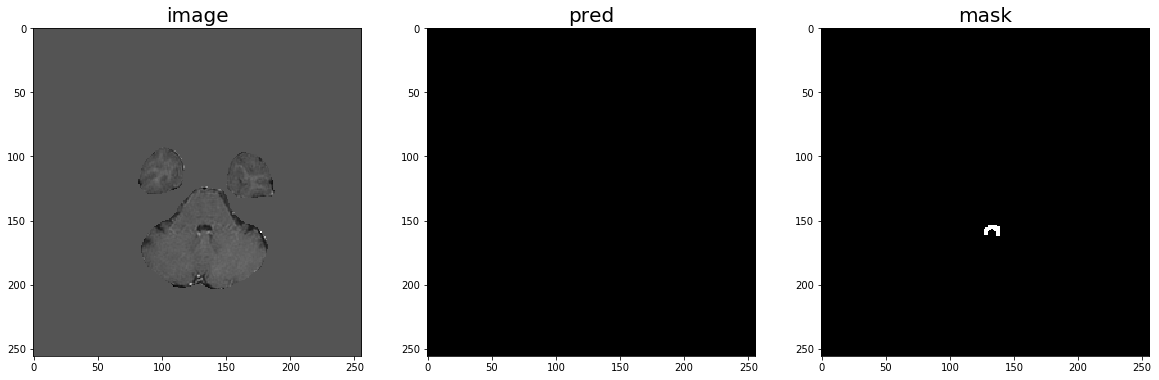

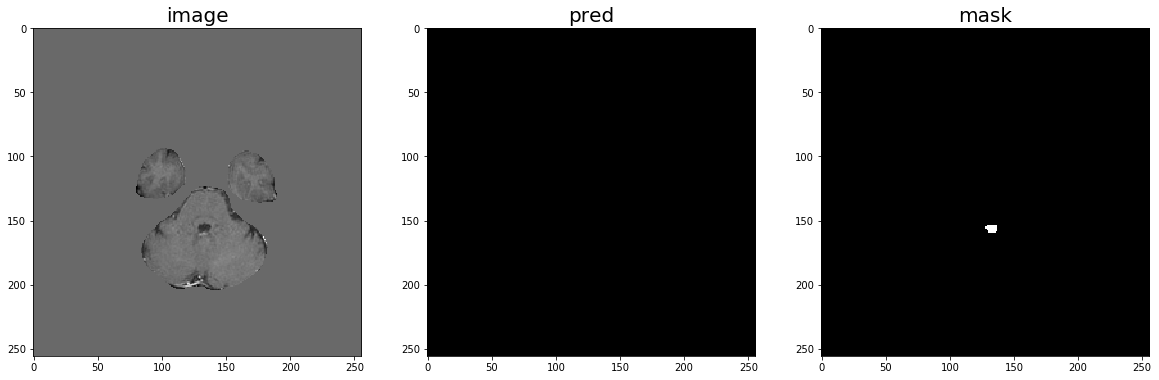

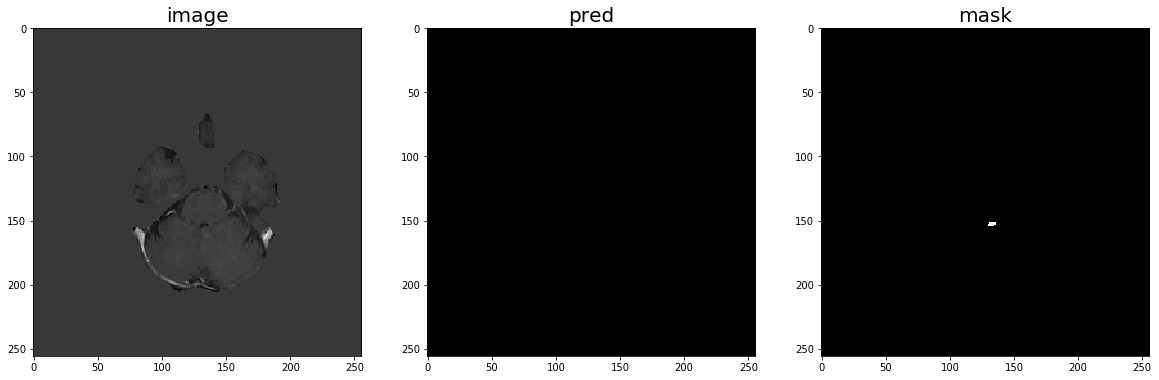

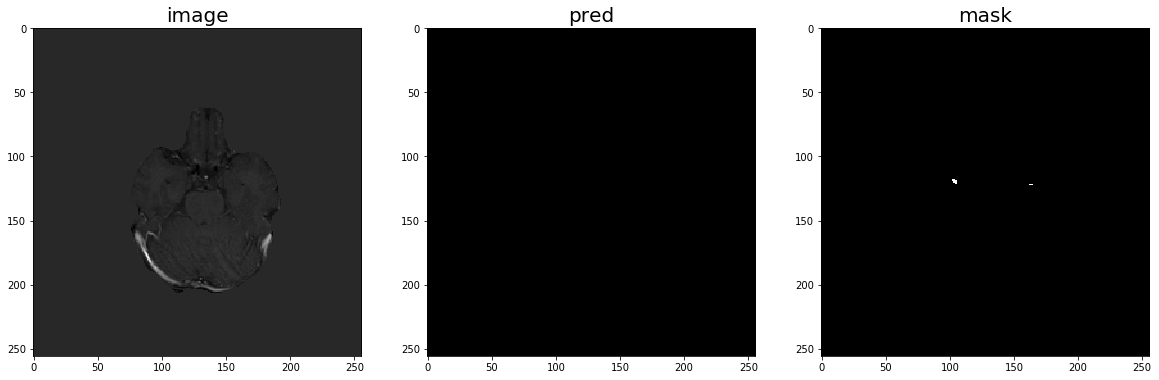

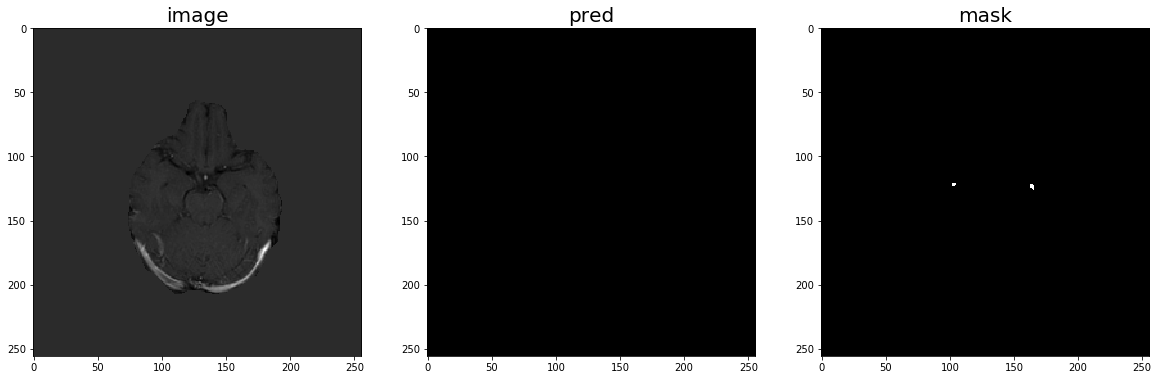

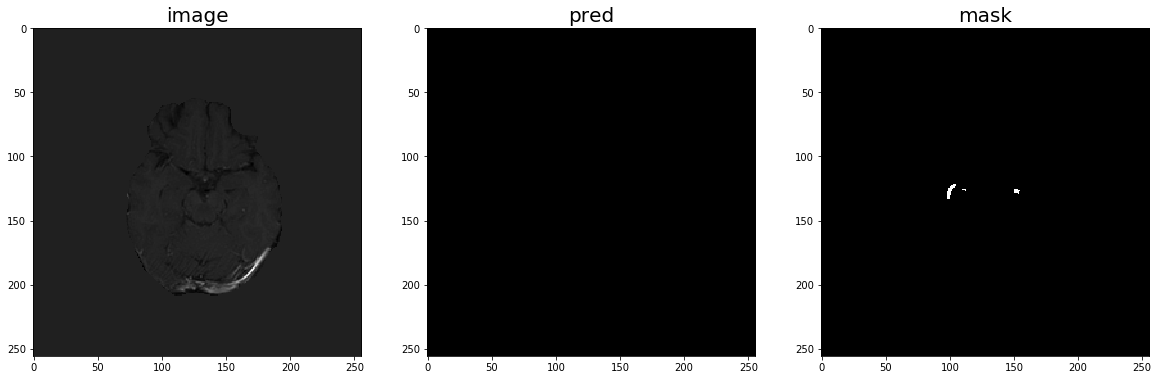

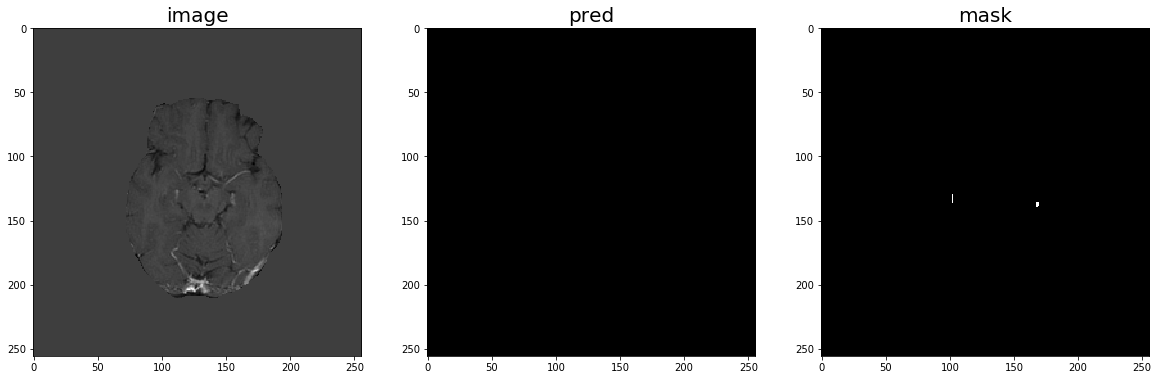

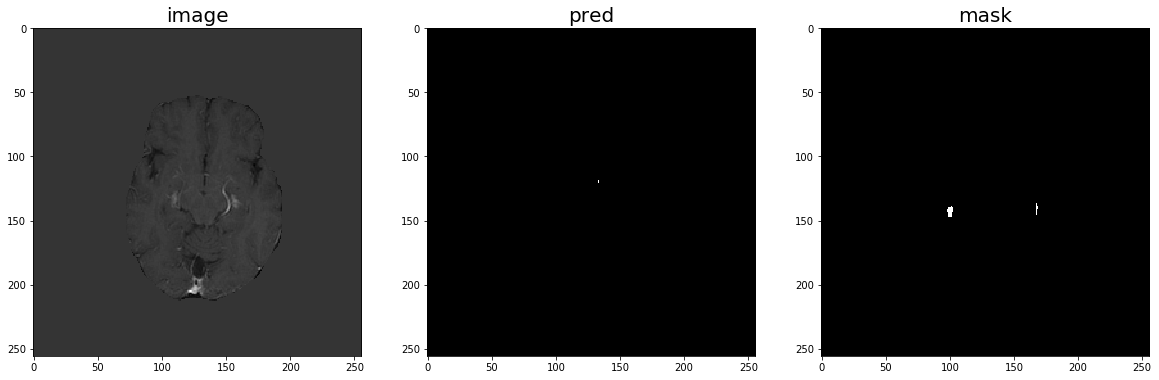

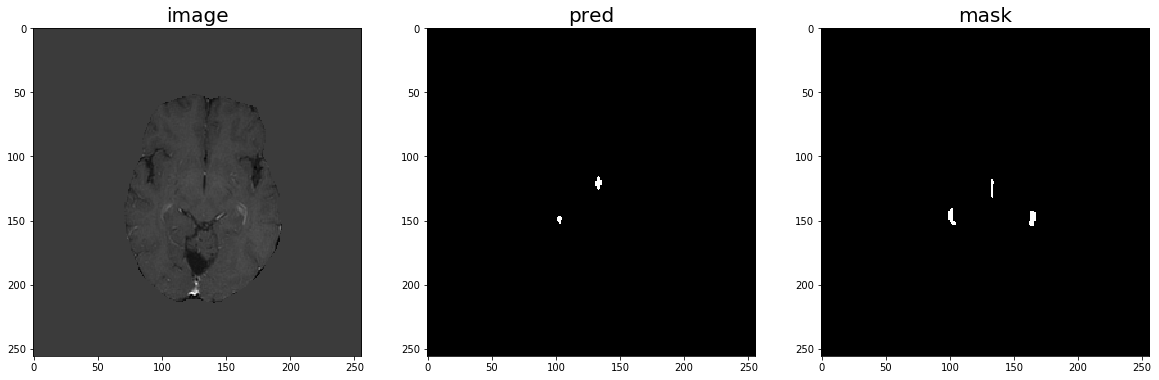

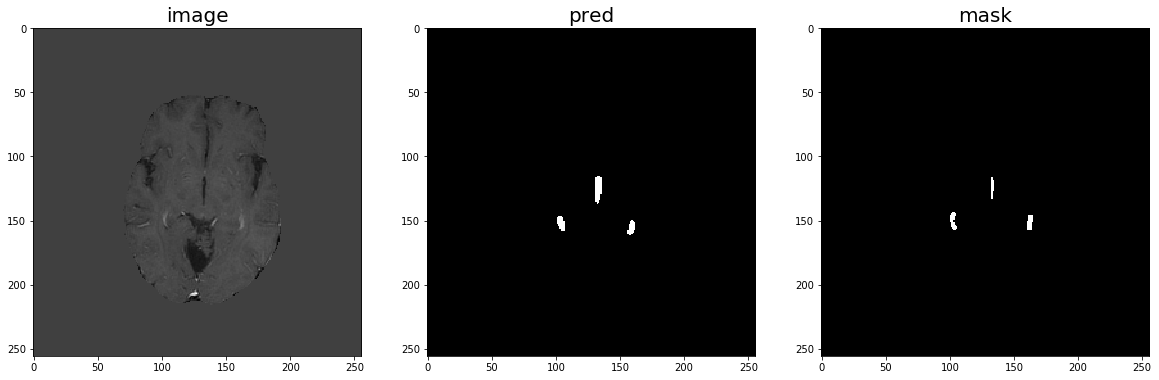

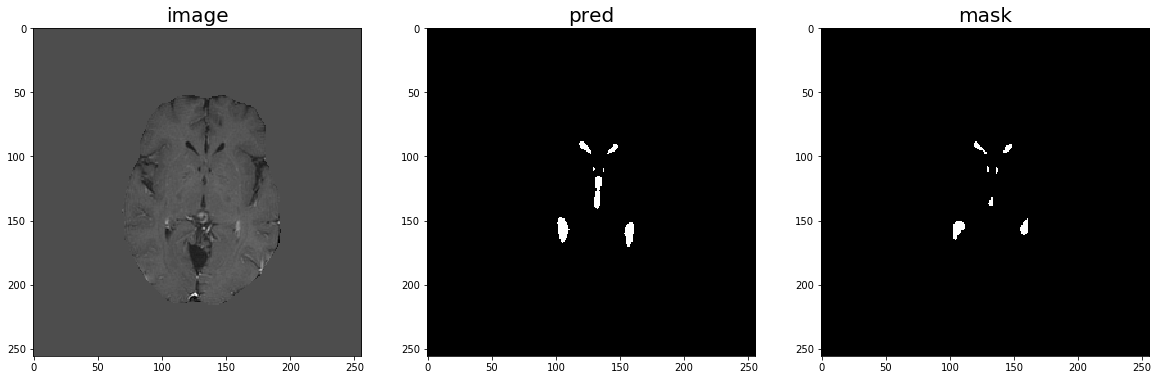

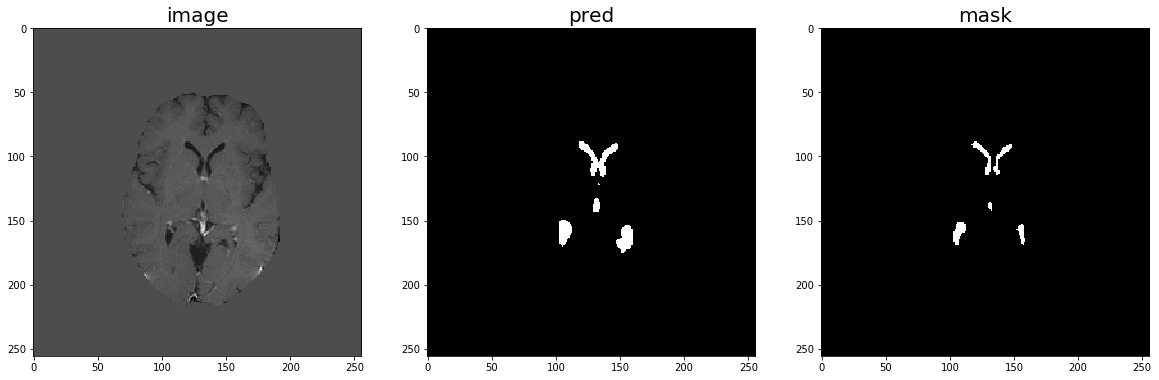

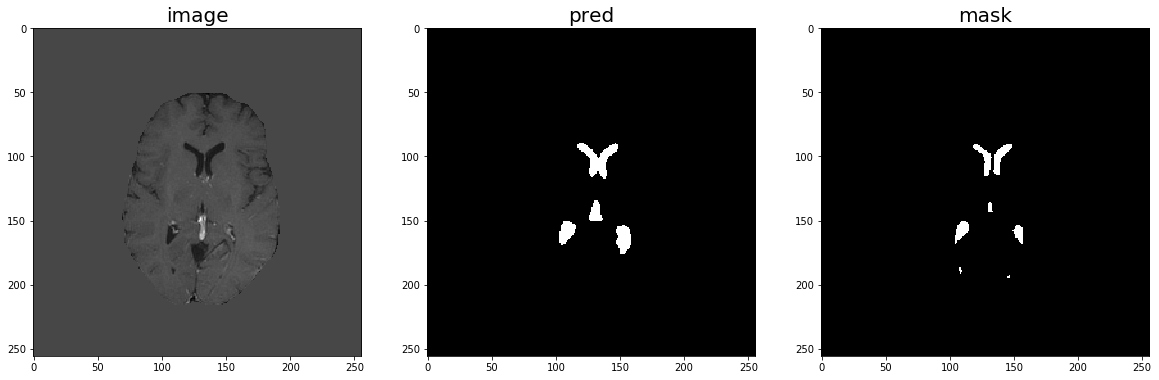

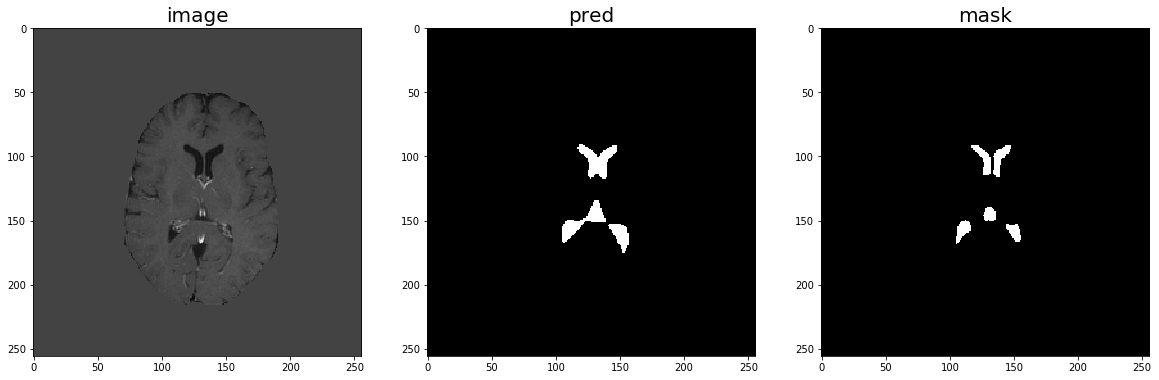

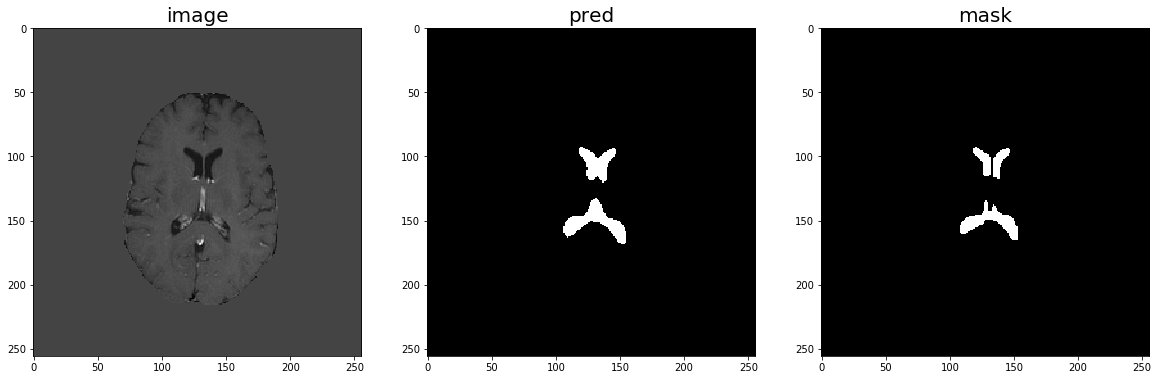

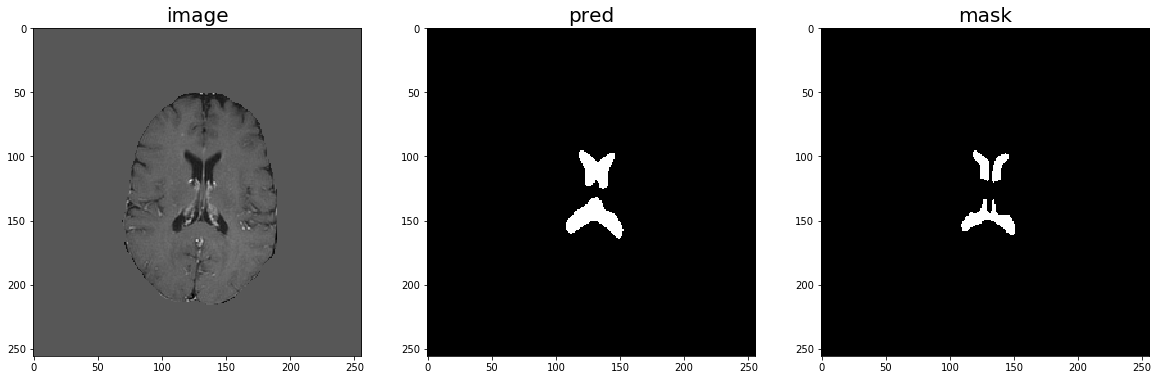

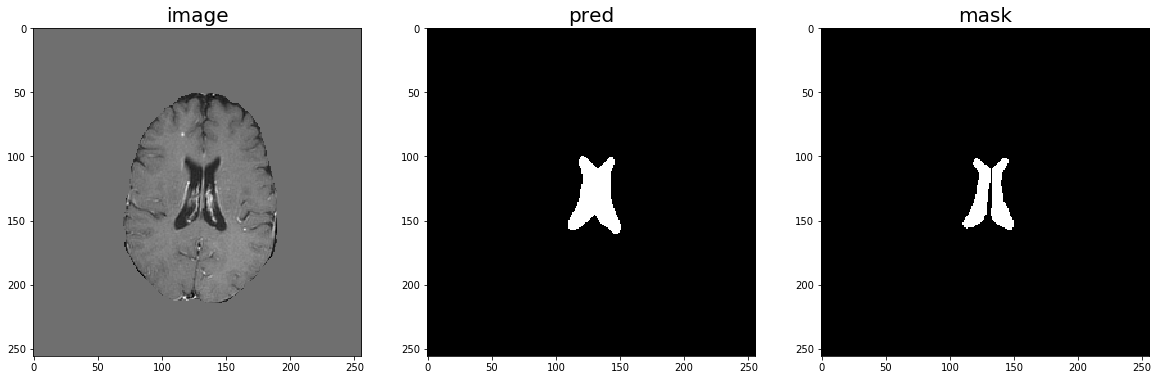

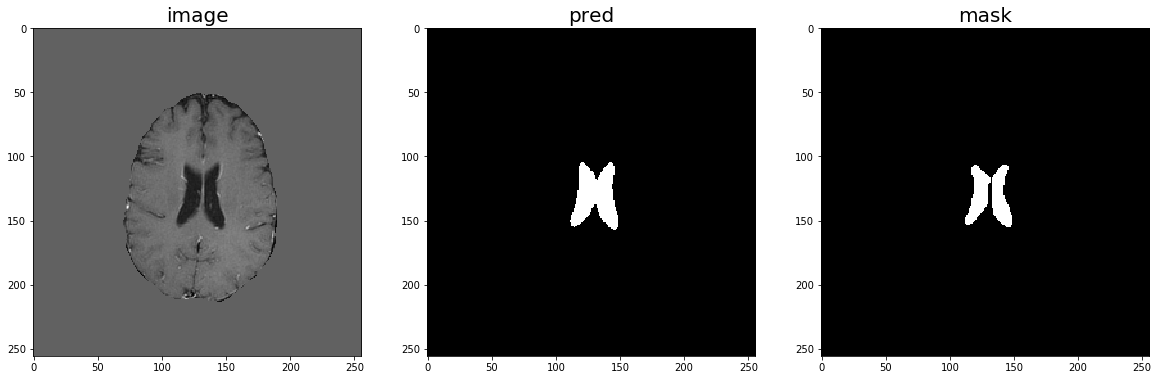

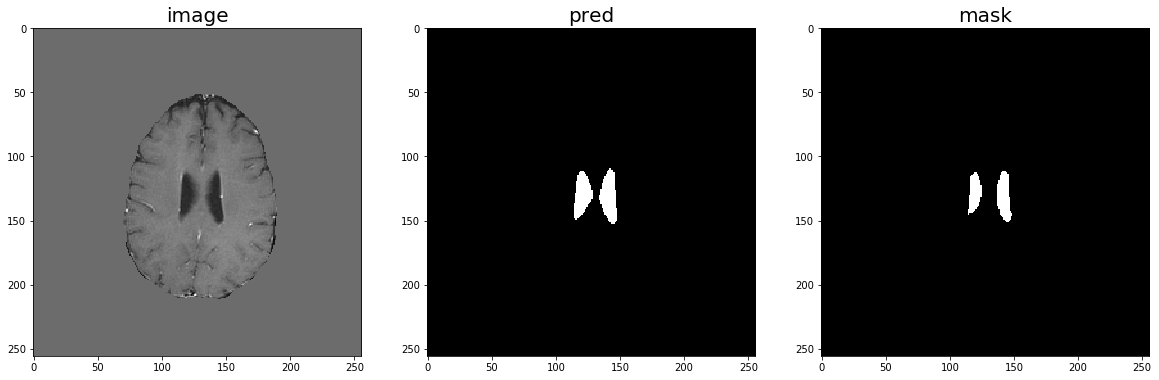

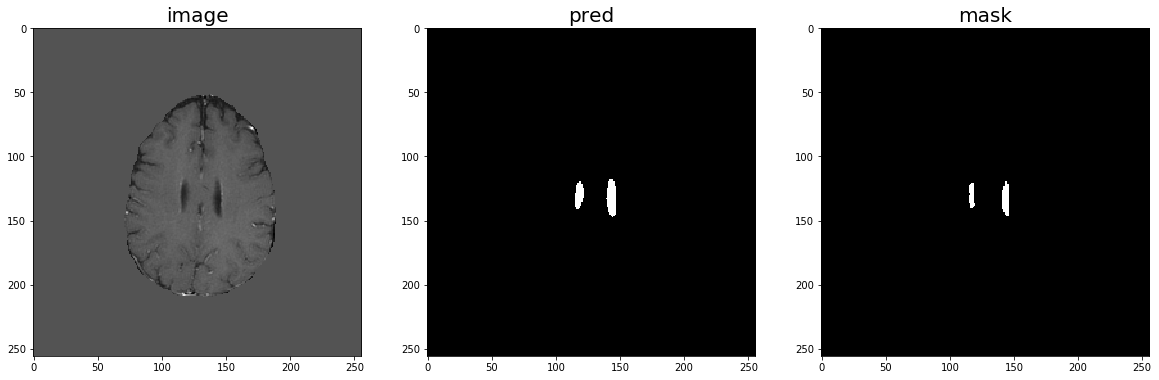

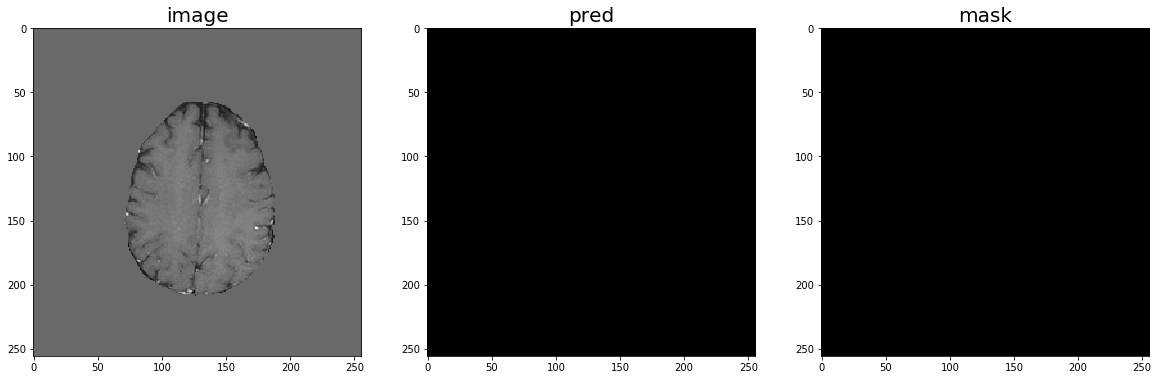

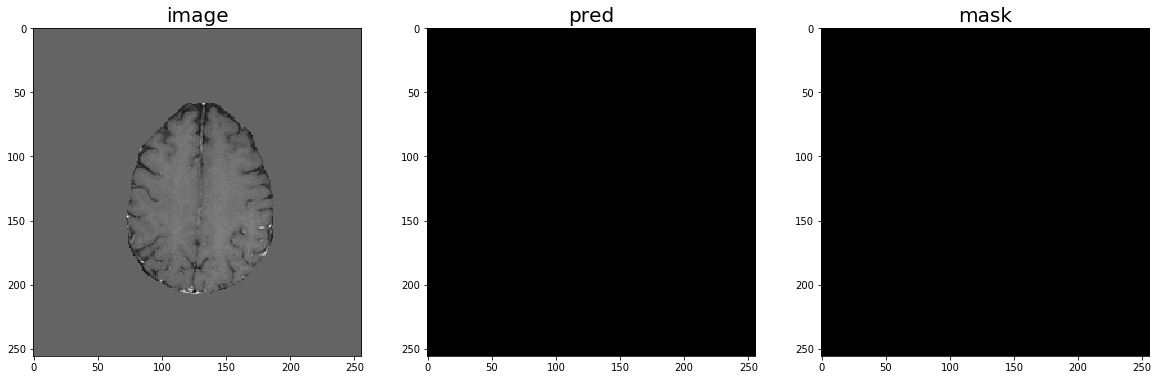

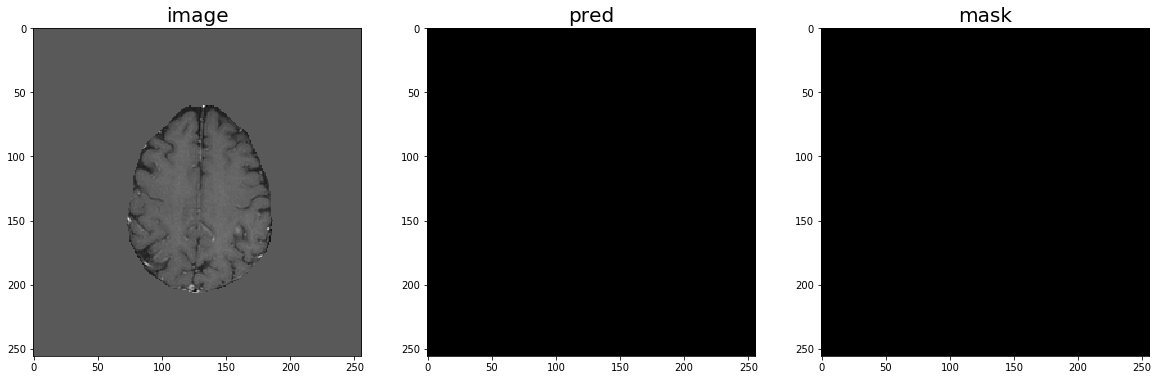

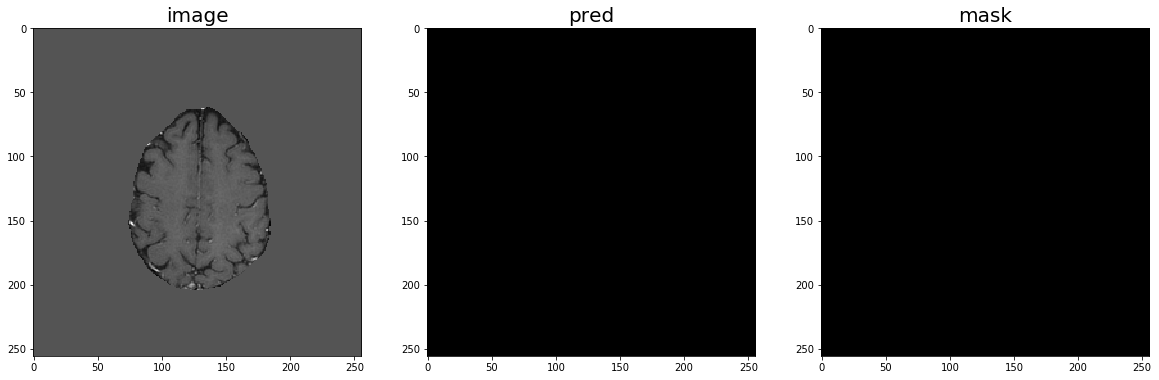

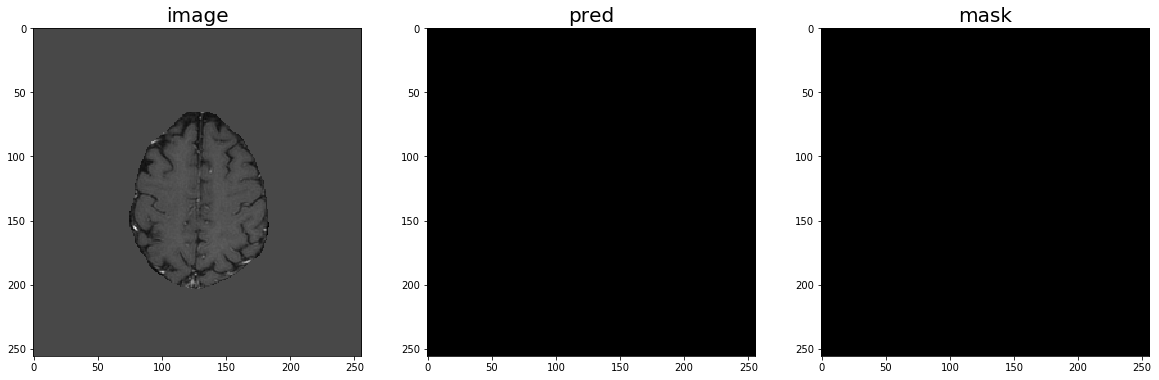

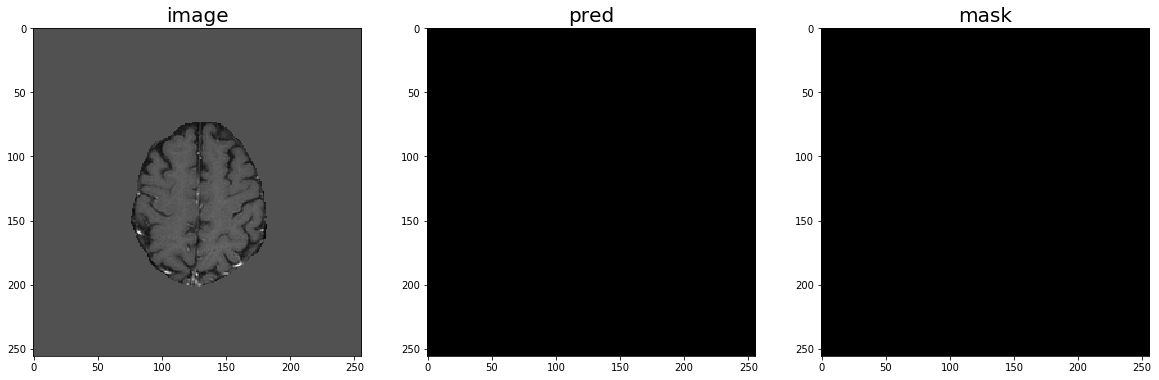

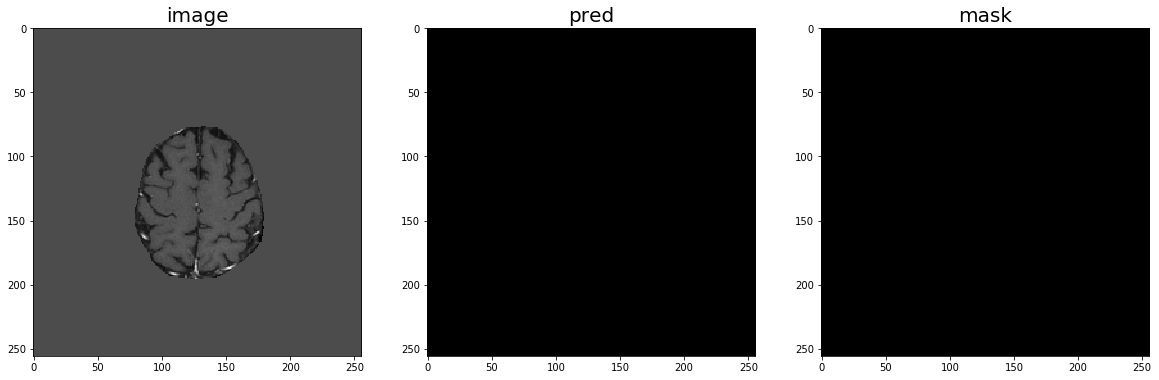

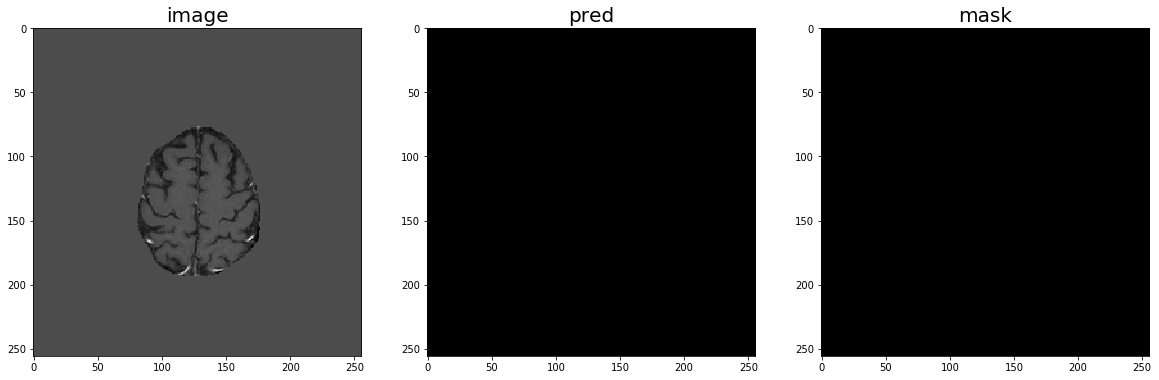

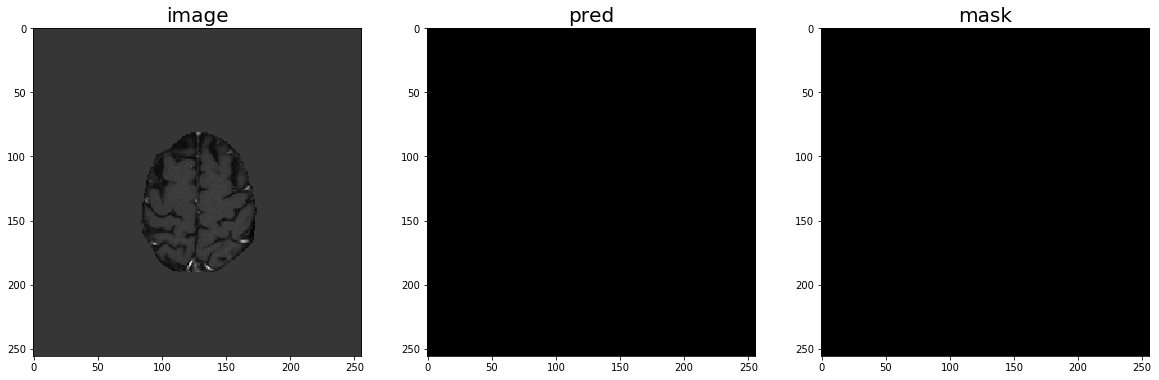

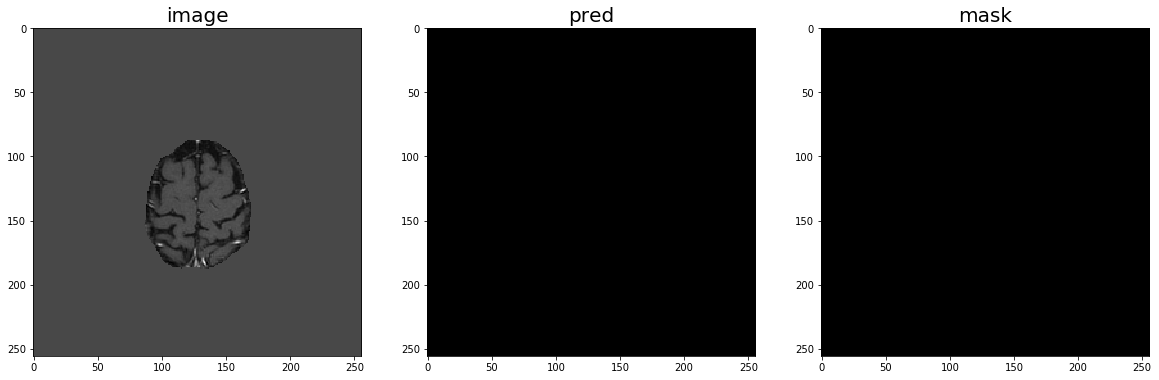

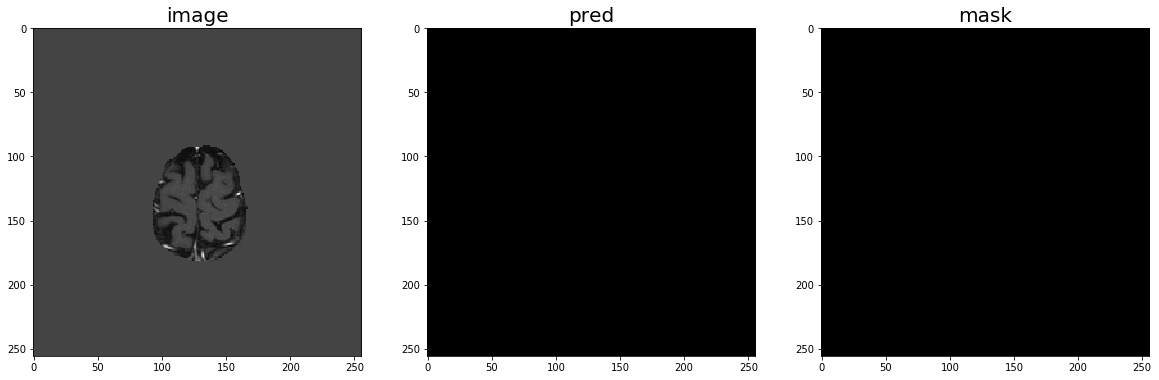

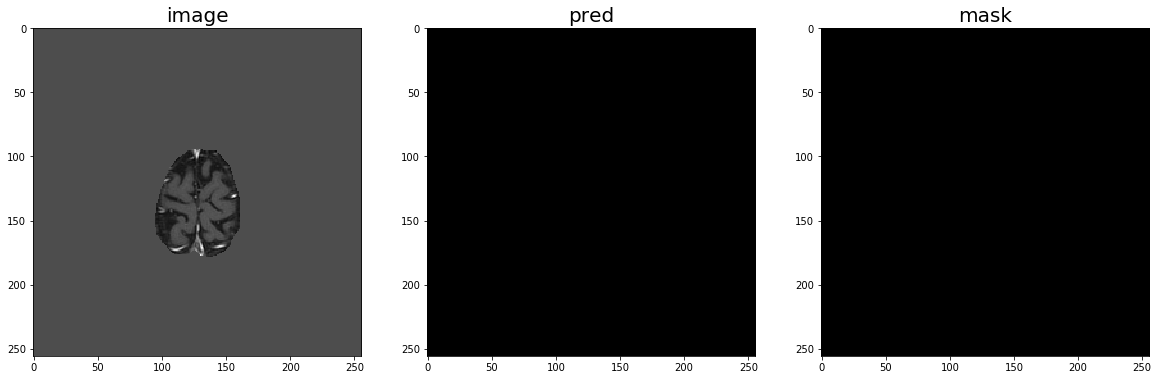

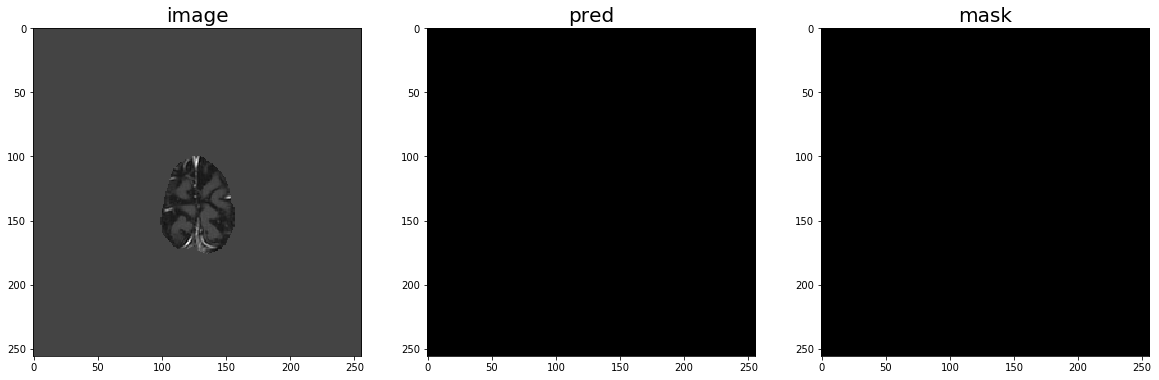

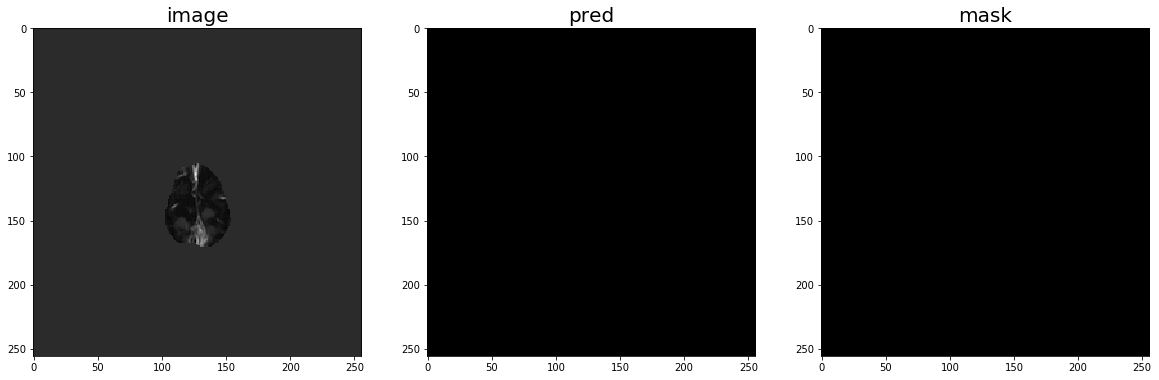

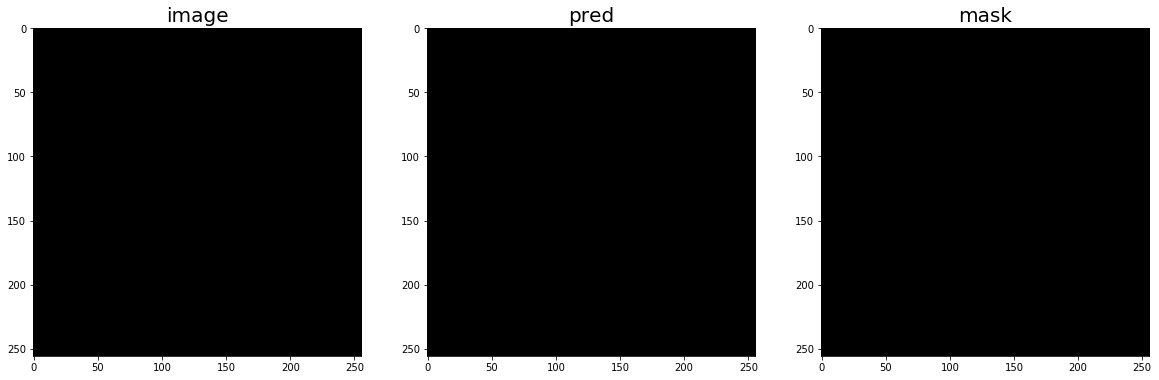

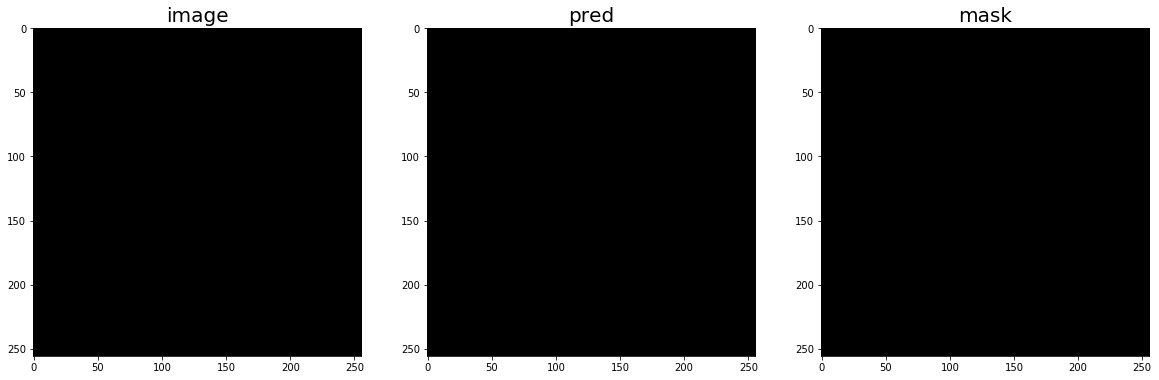

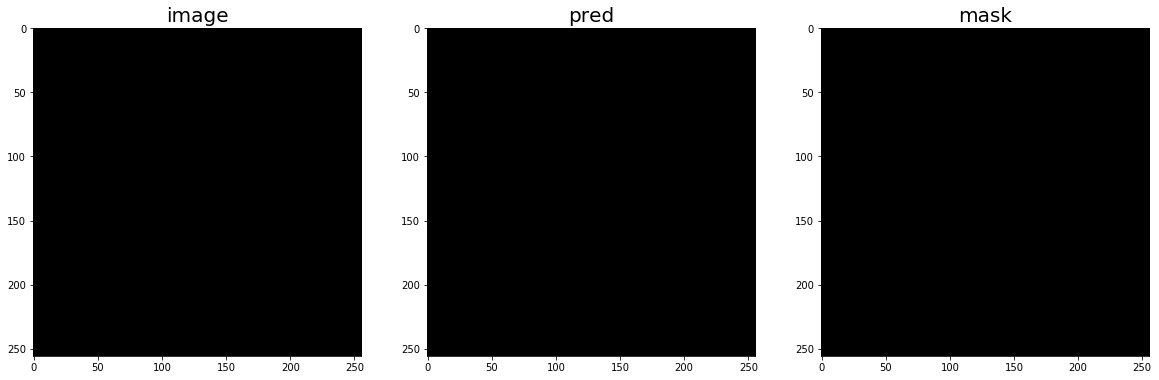

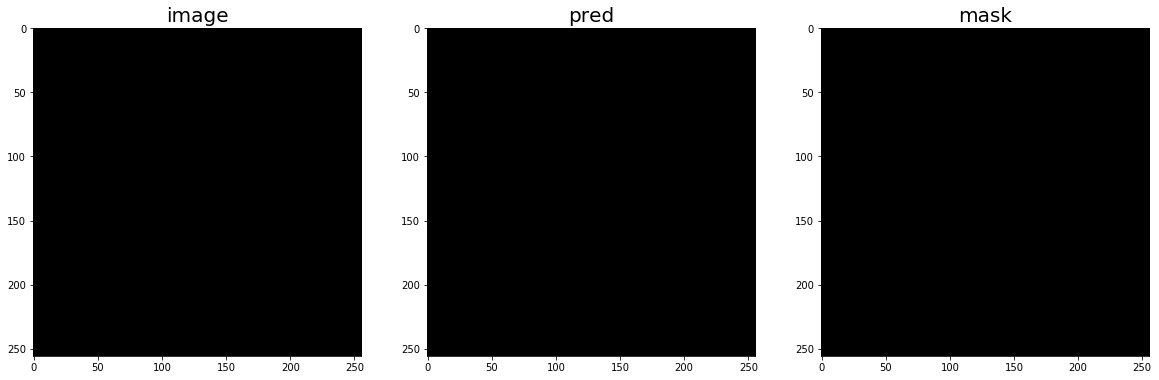

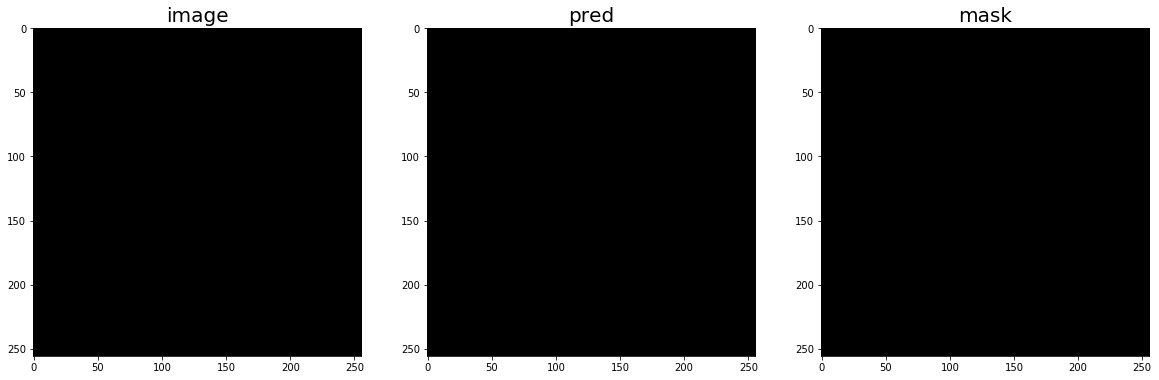

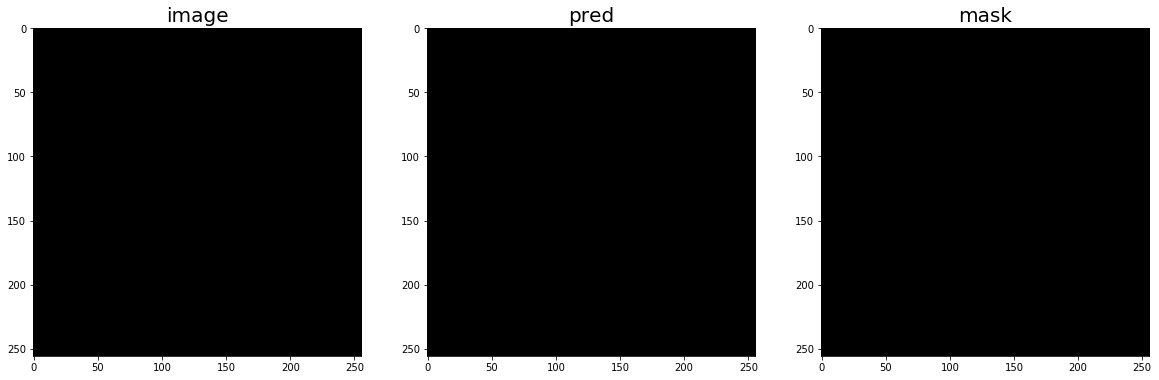

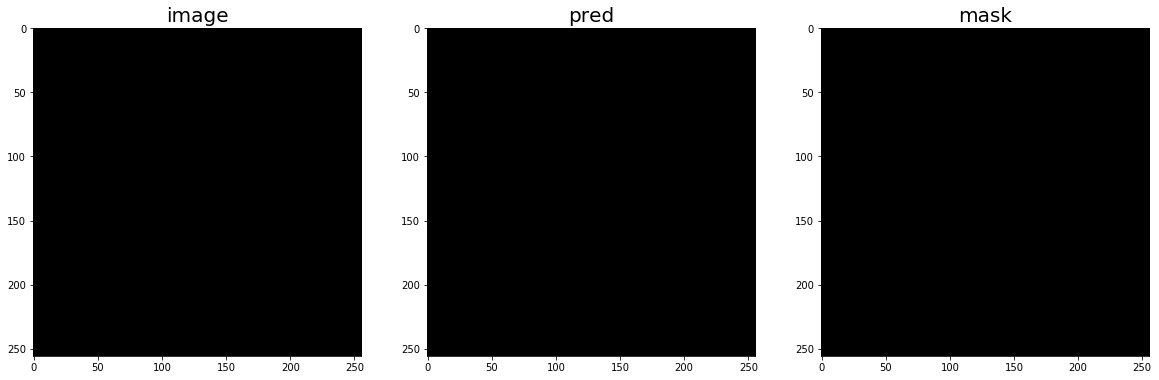

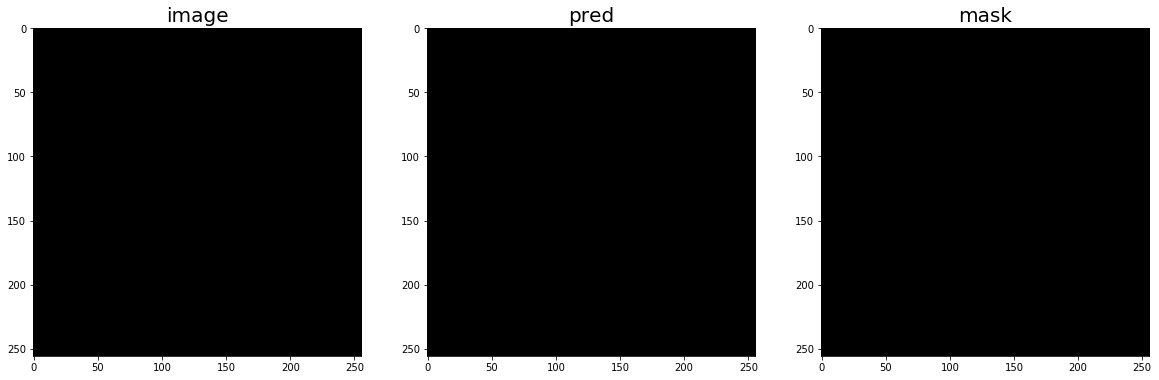

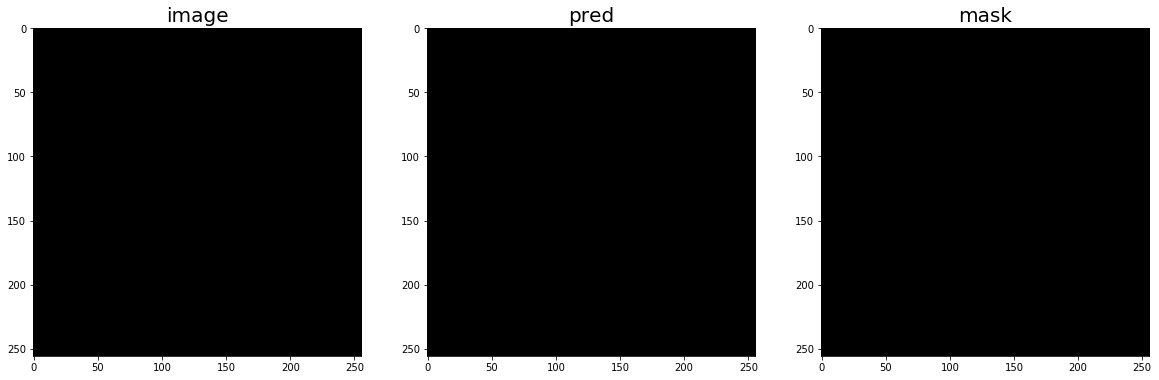

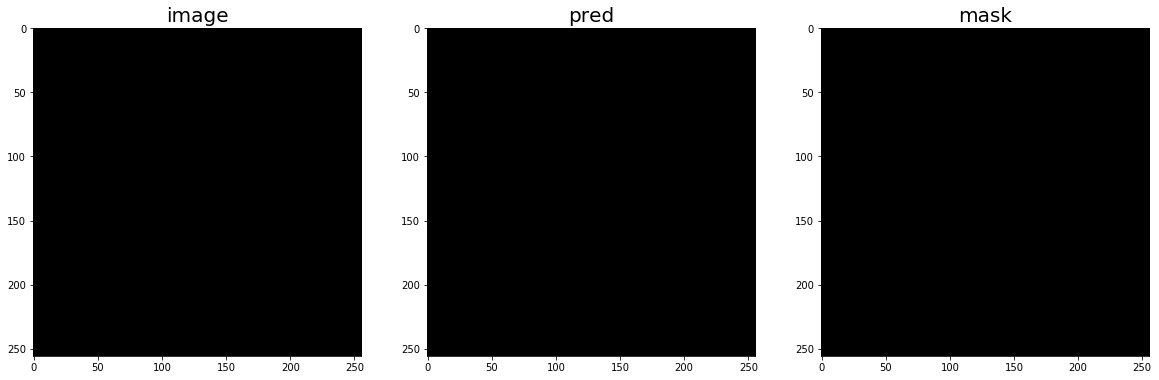

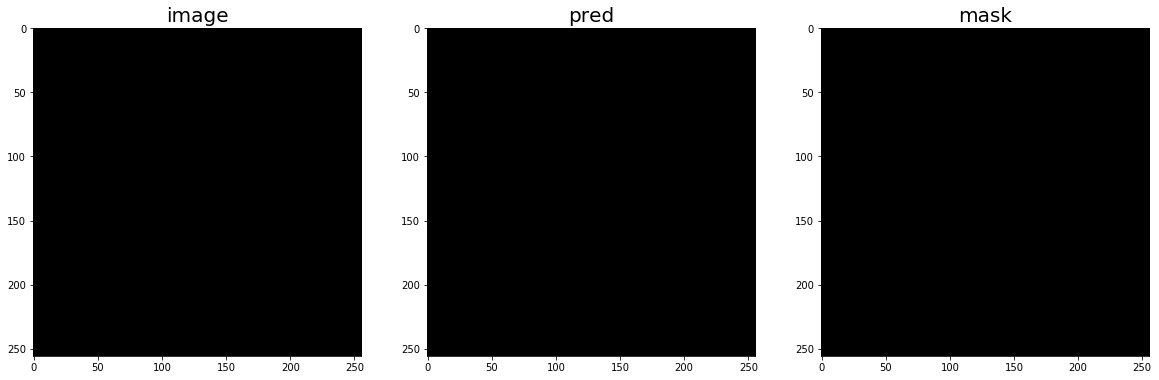

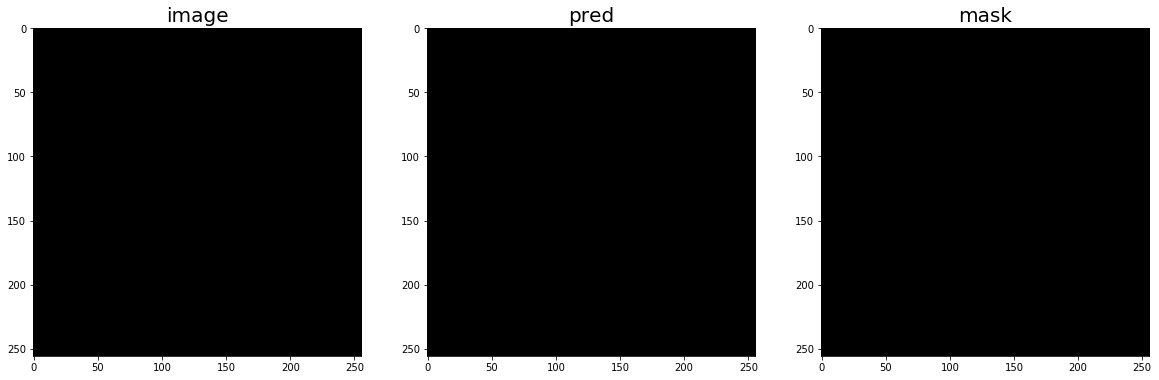

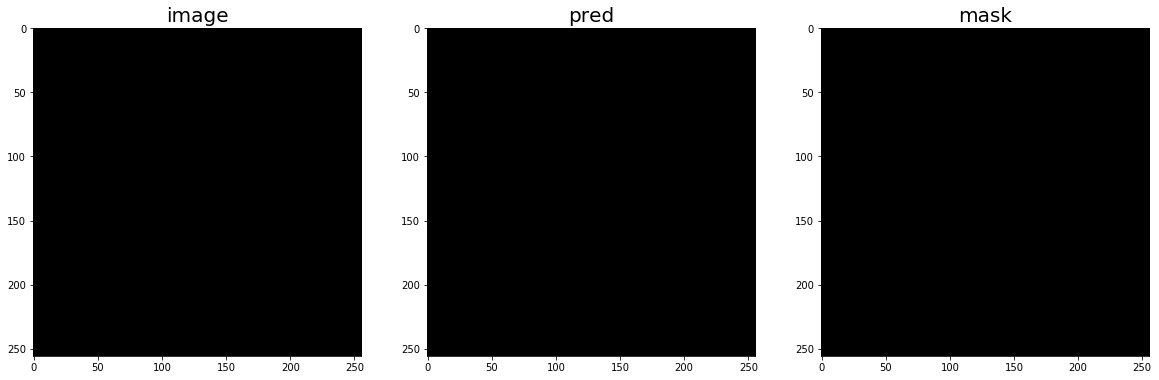

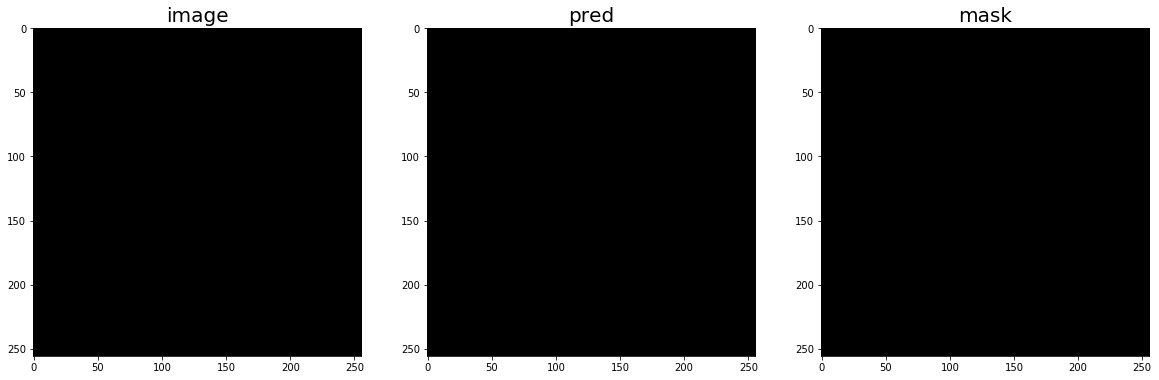

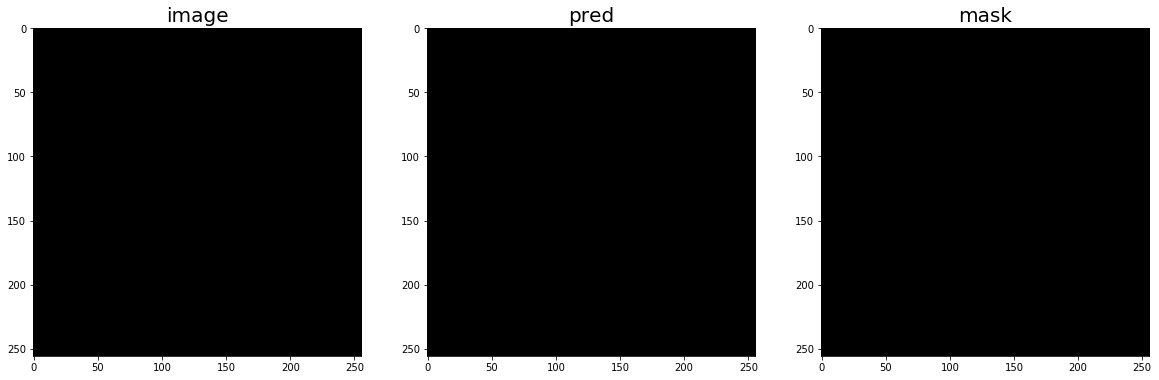

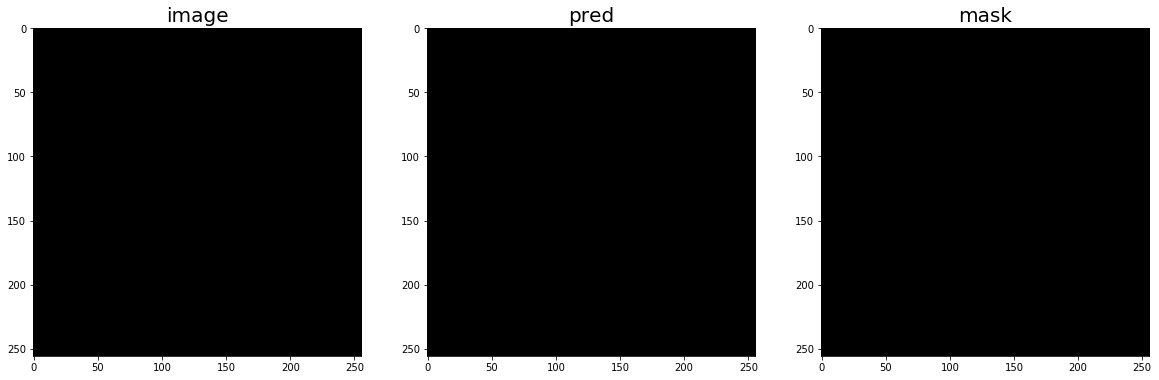

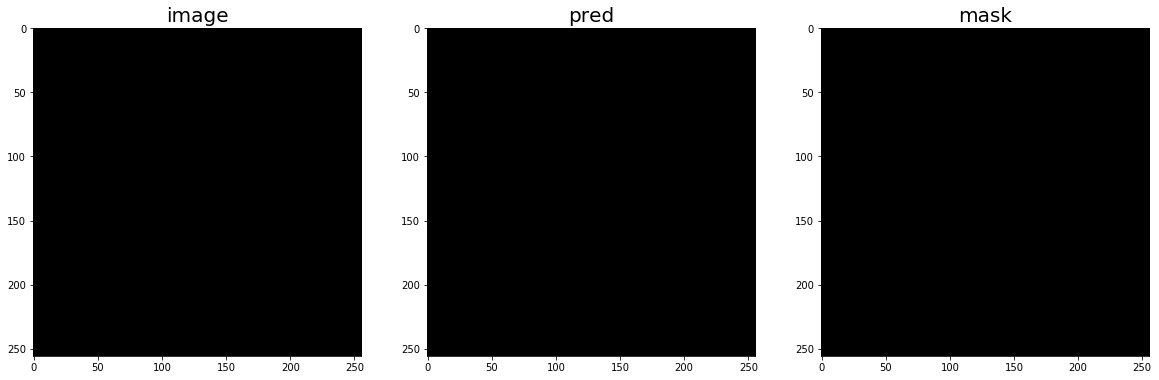

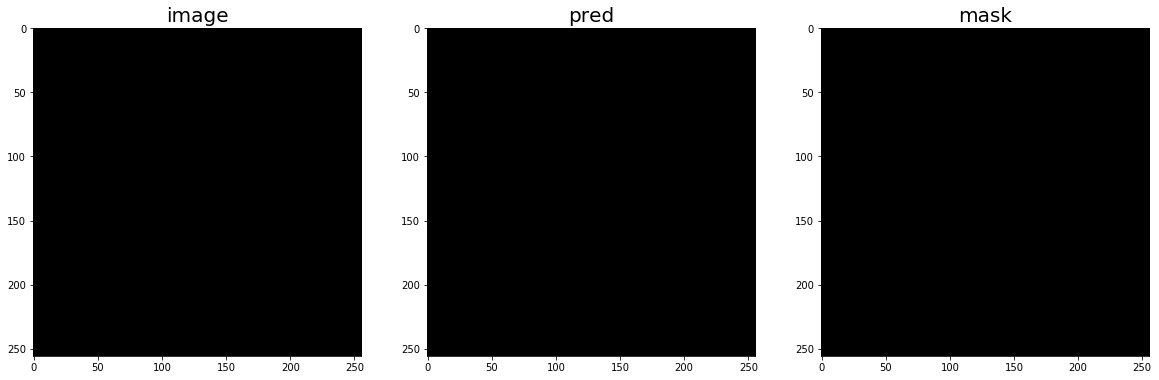

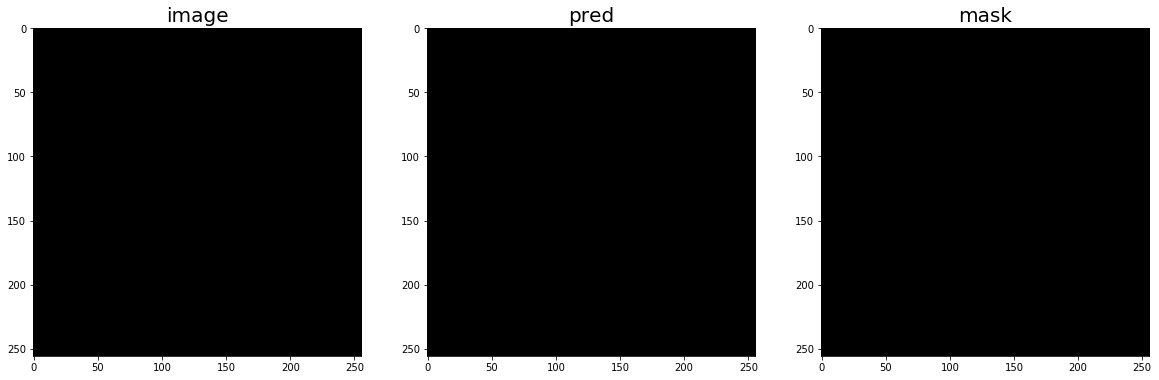

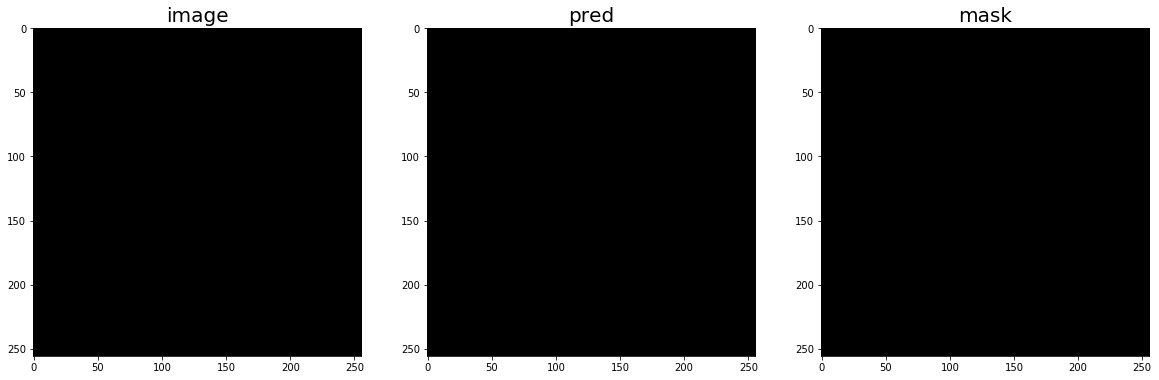

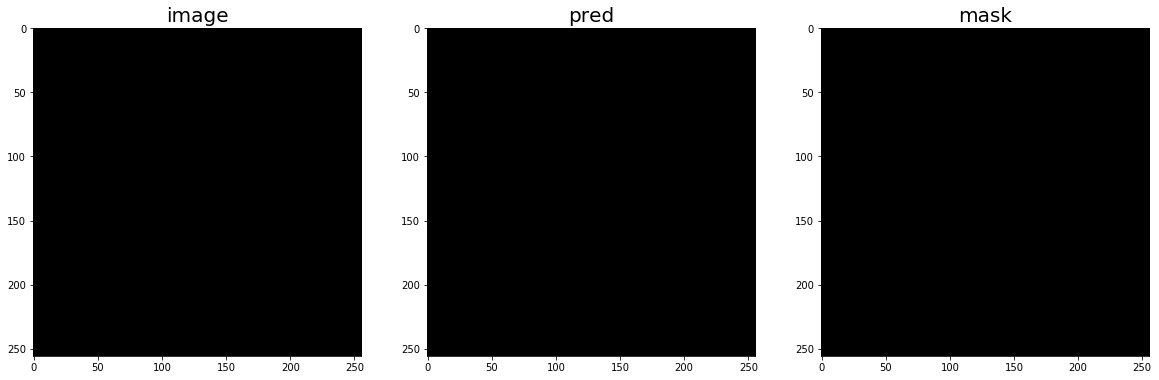

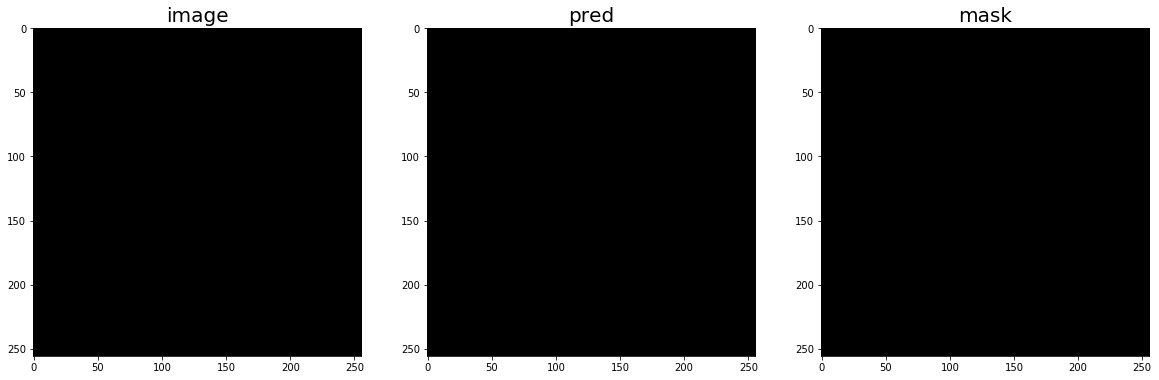

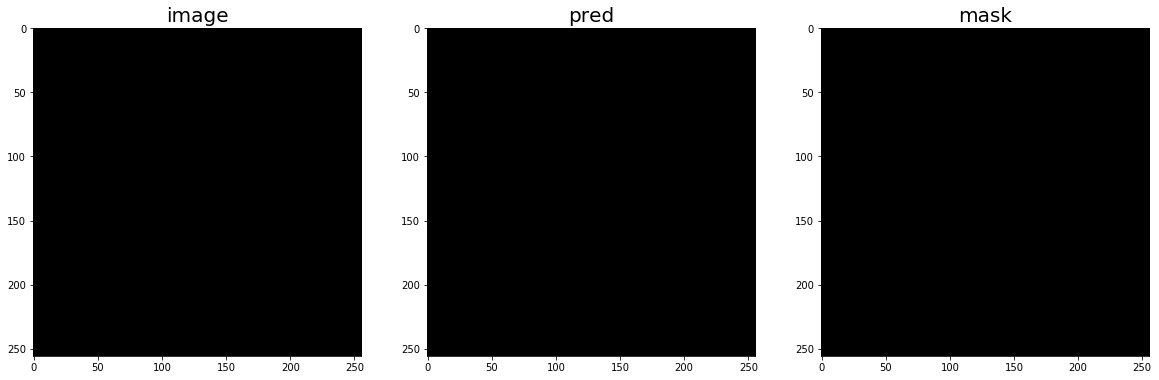

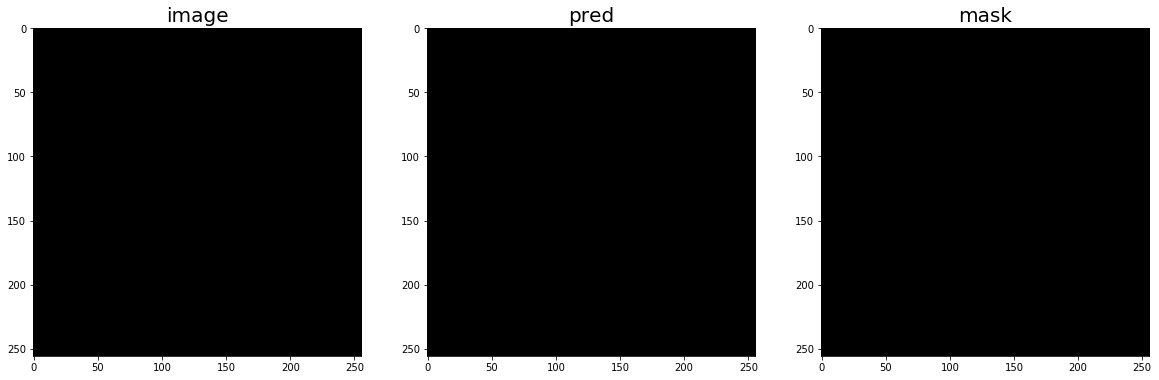

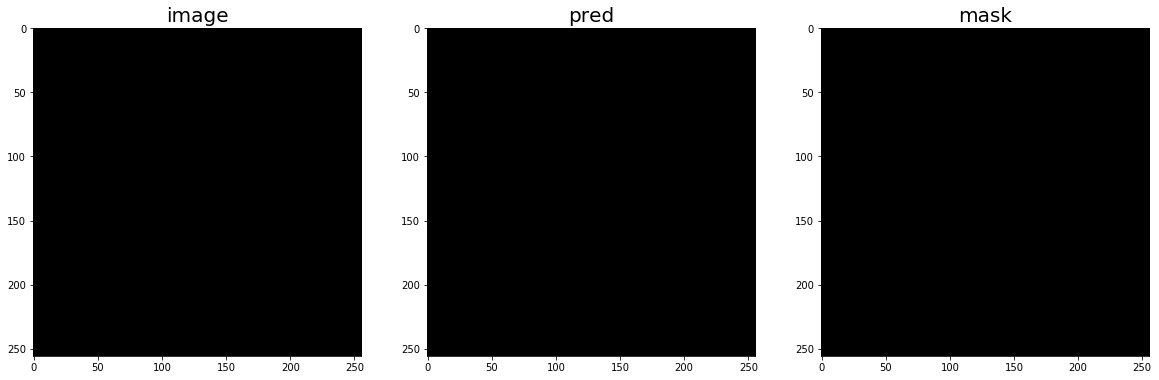

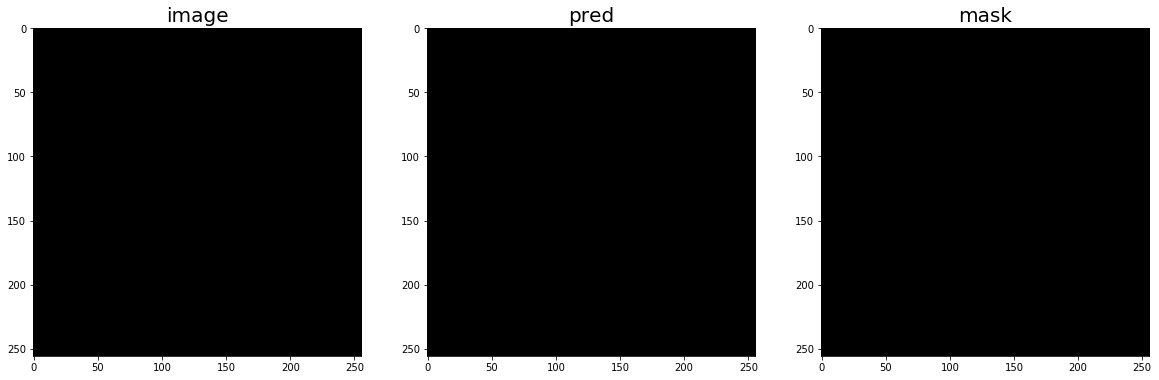

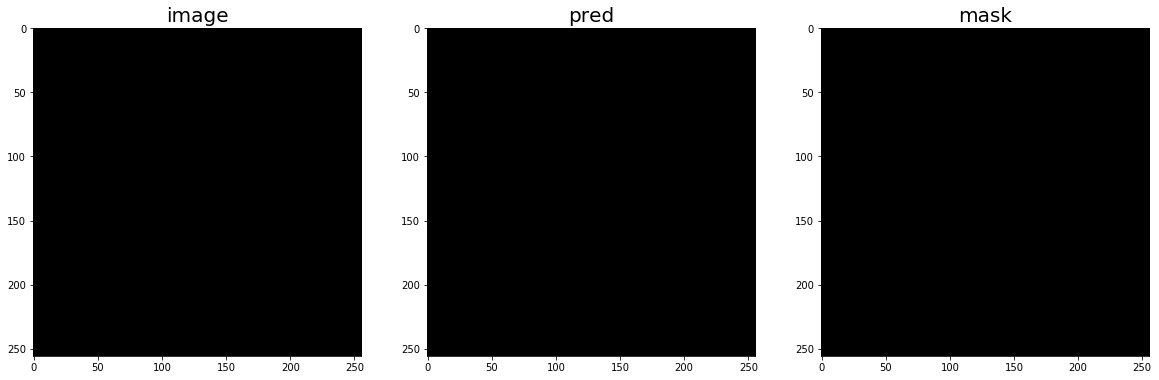

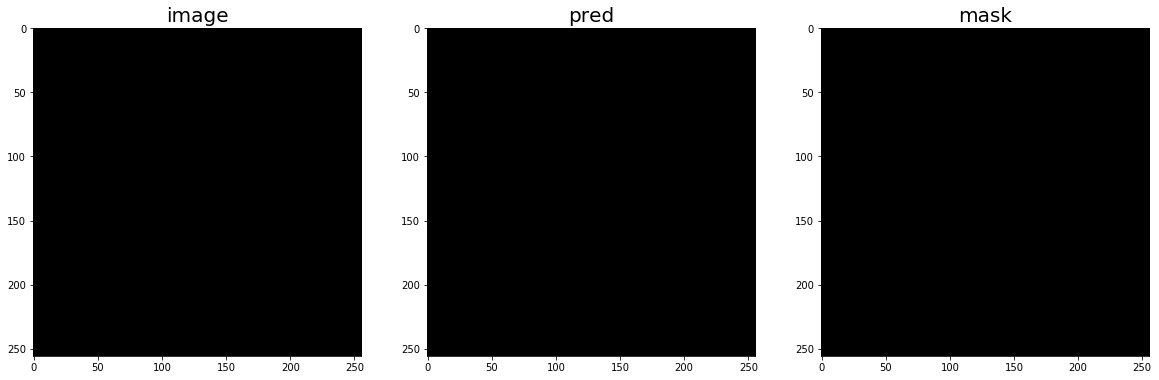

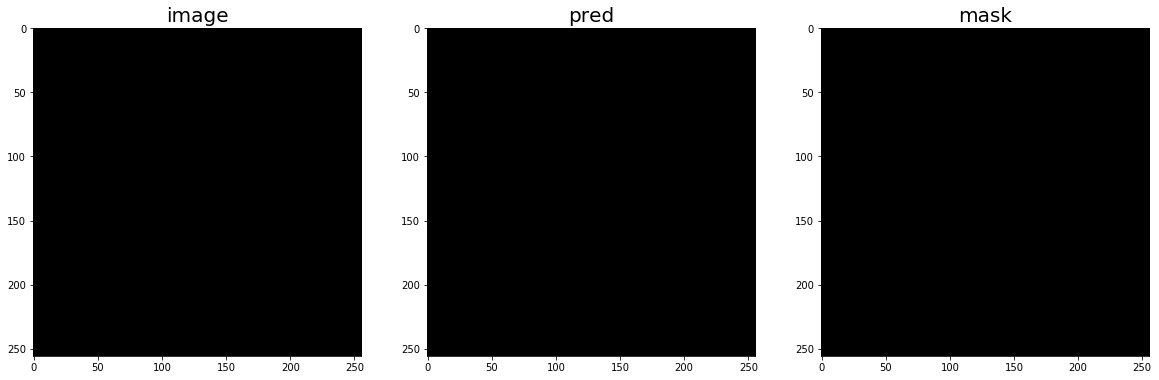

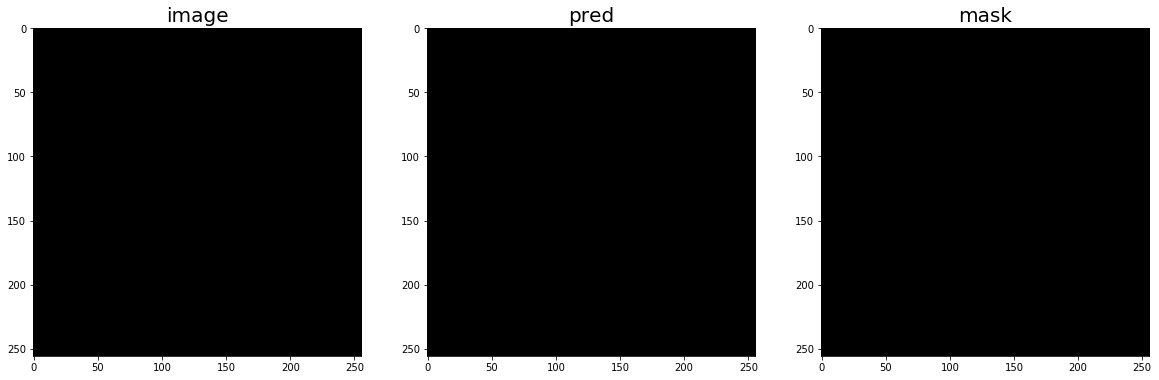

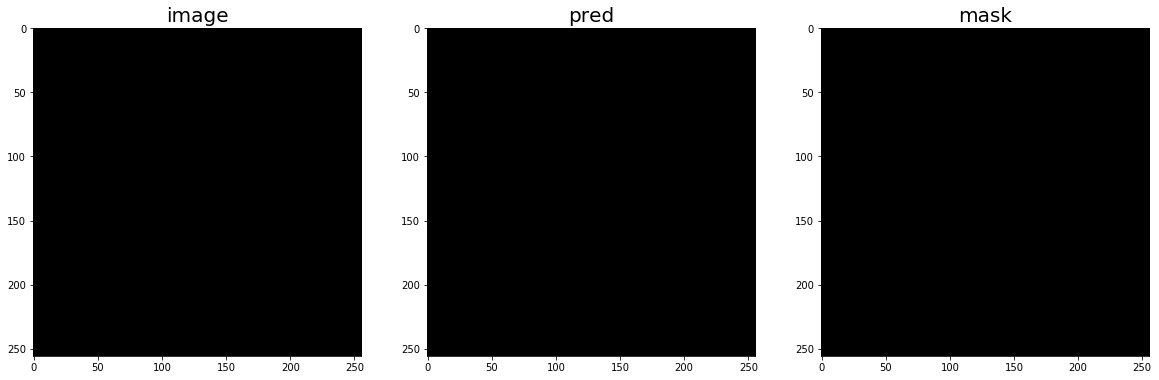

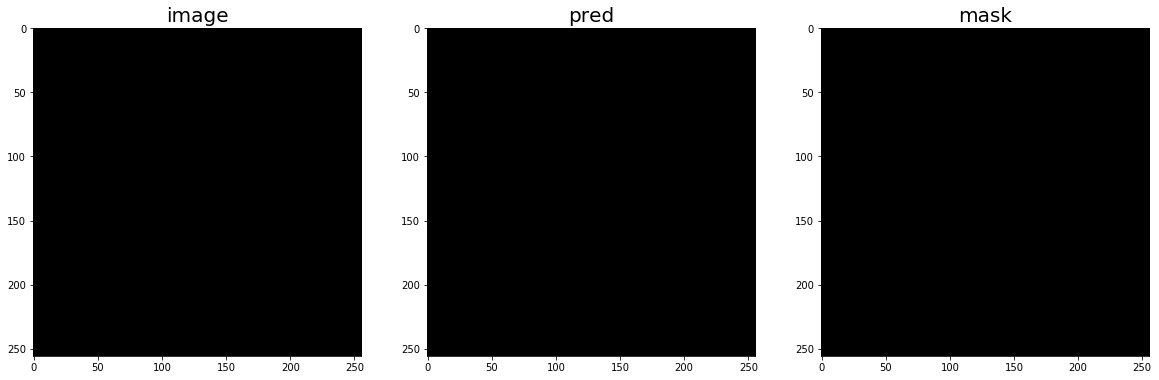

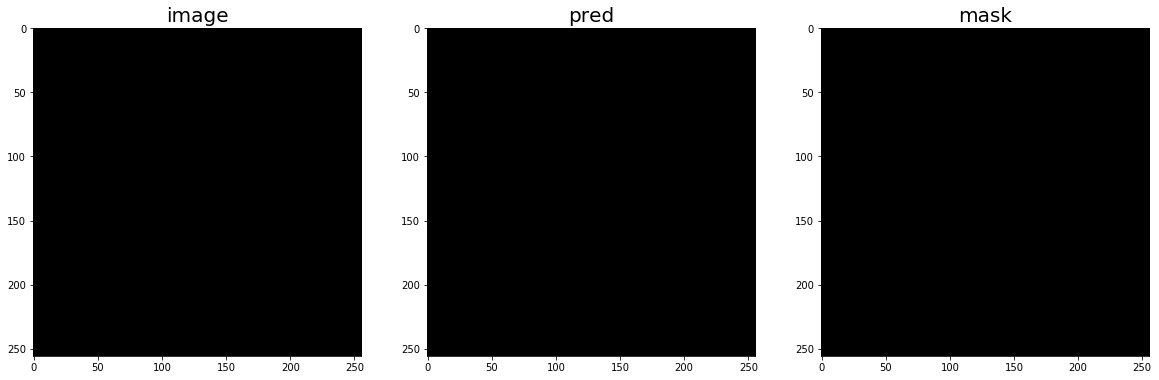

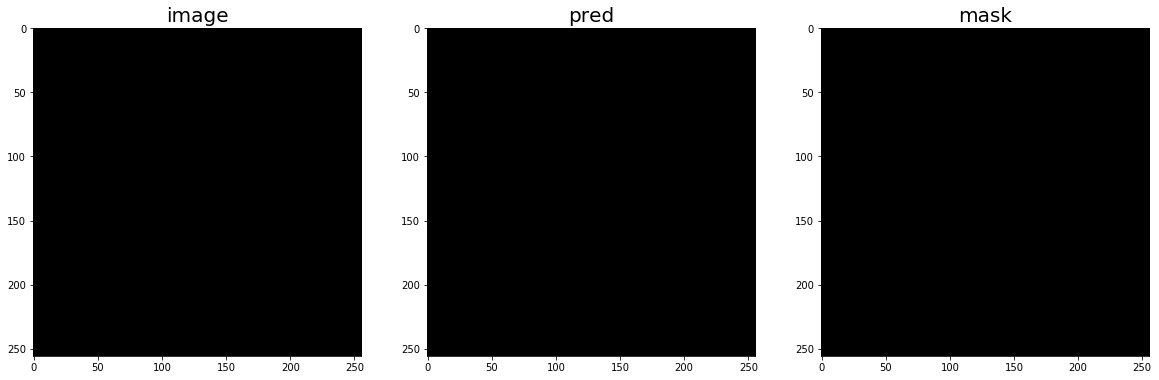

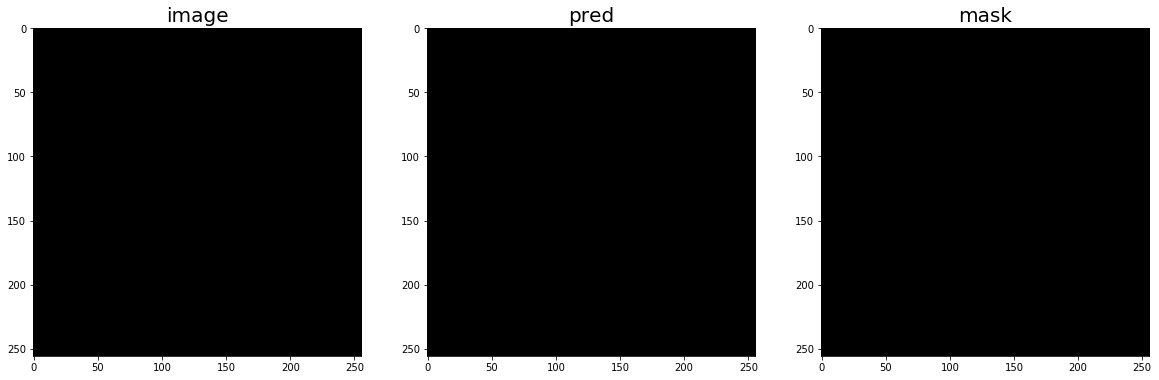

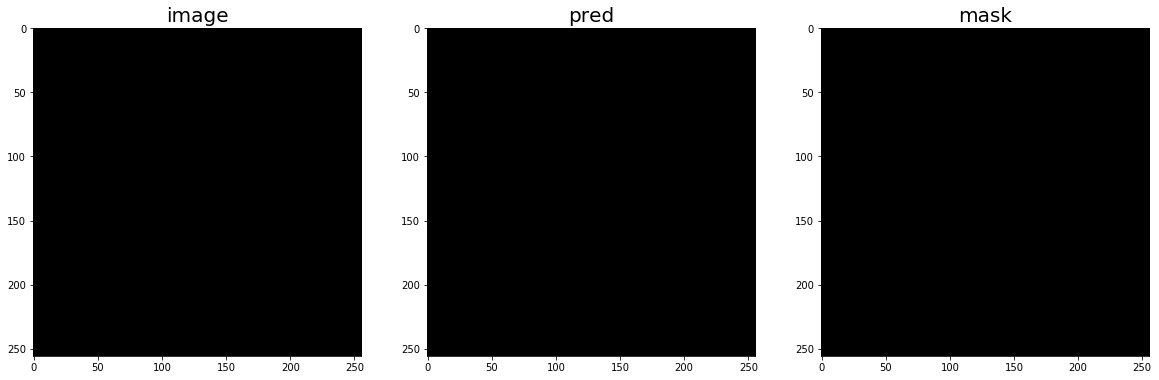

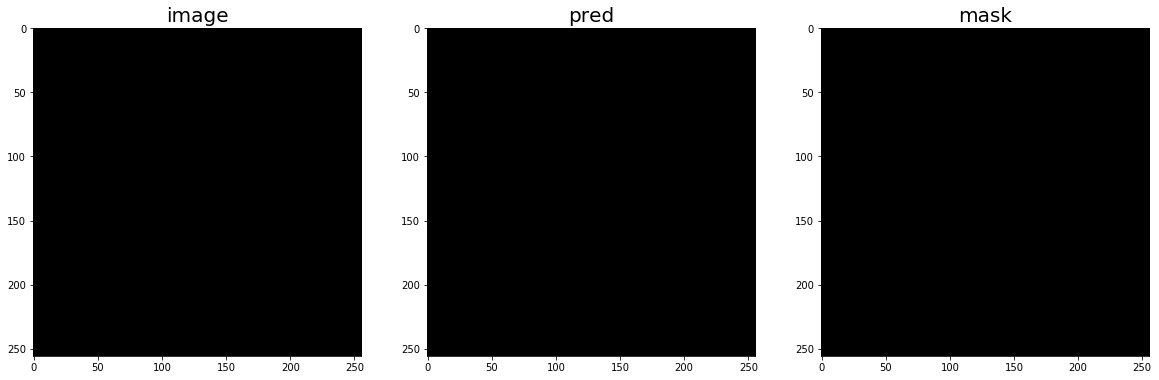

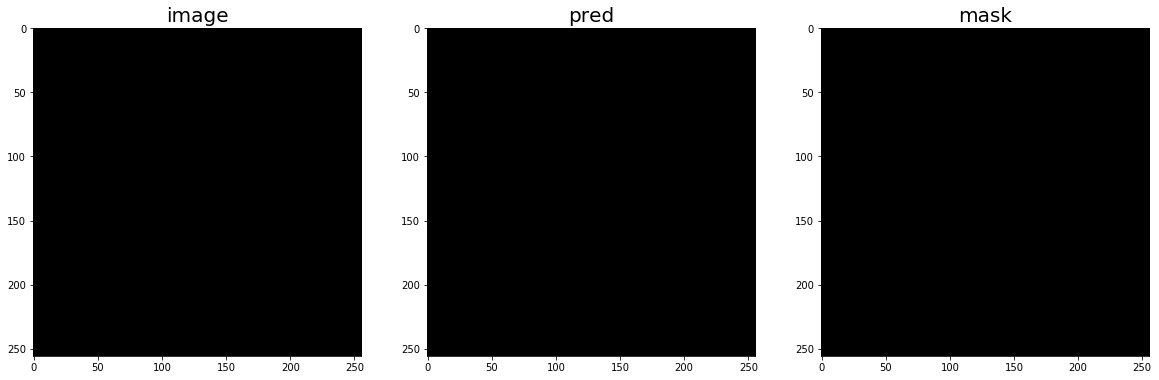

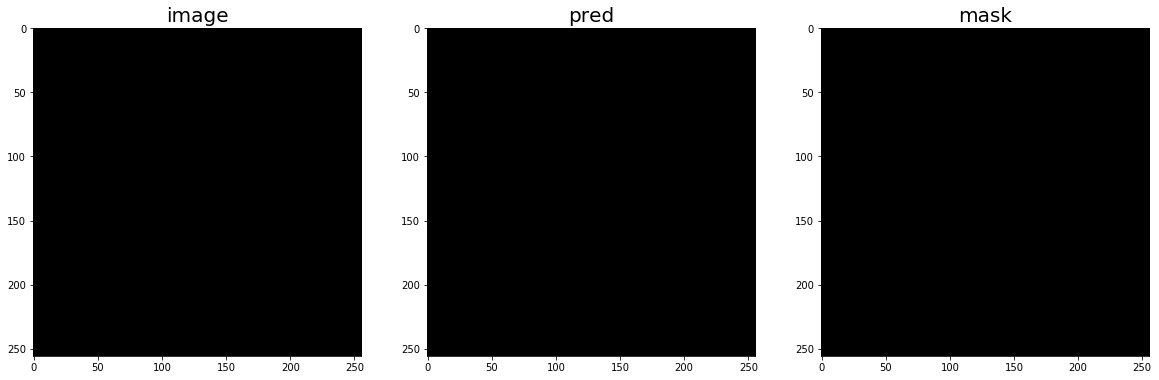

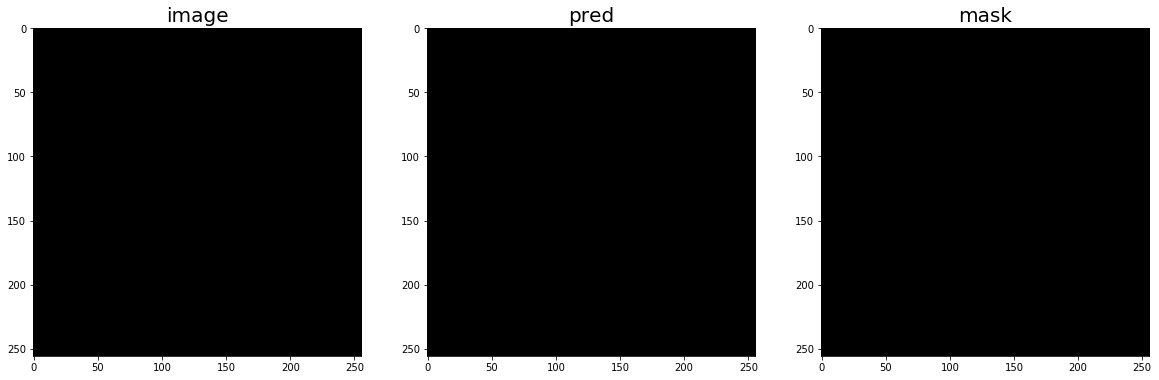

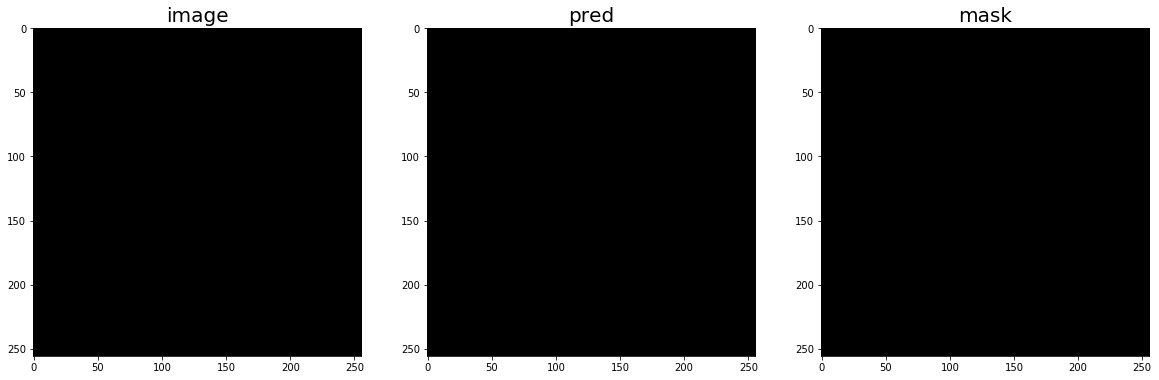

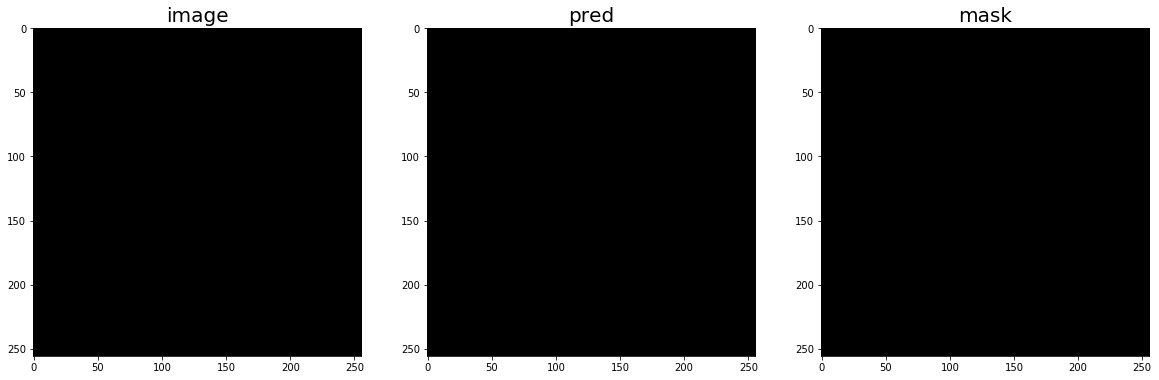

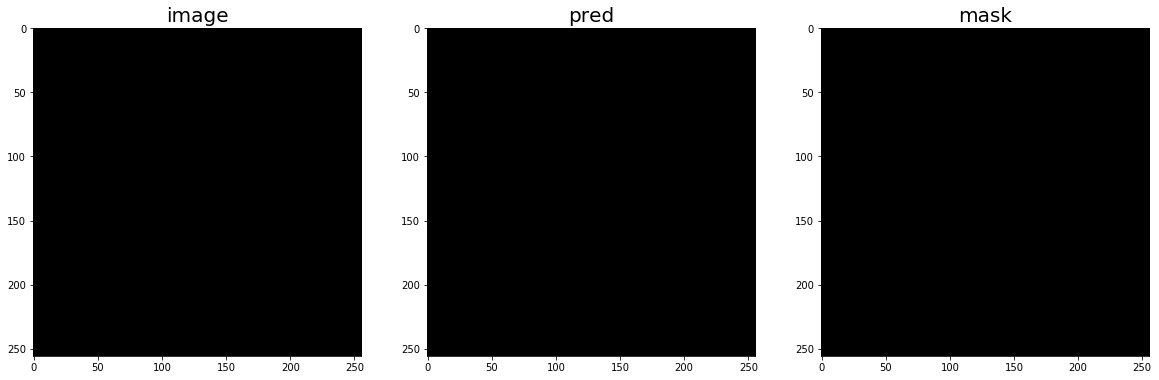

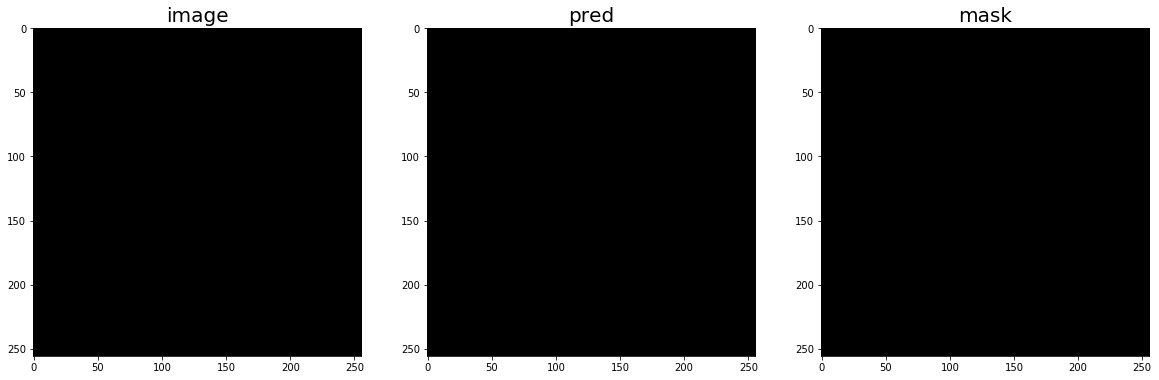

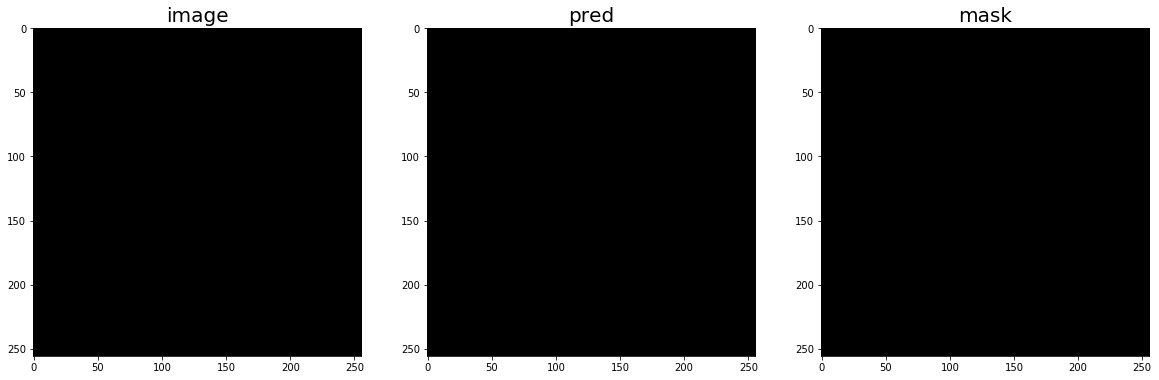

In [17]:
IMG_NUM = 5
image = images[IMG_NUM]
pred = preds[IMG_NUM]
mask = masks[IMG_NUM]
for i in range(image.shape[0]):
    plot_predictions(image[i], pred[i], mask[i])

In [12]:
eval_preds(masks, preds)

0.8124287579223605